In [181]:
##因为老师需要我们采用不同的算法，所以我们需要采用不同的算法进行分析
##.LightGBM
##.RandomForest
##.XBoost
##.深度学习(基于pytorch框架） 
########我在学pytorch
####我们硬件其实不是很好，许老师又把我们的机器学习机器关了，大家到kaggle上跑，提交，判分结果截个图发群里我就知道大家起码看一遍了
#####提交有格式要求的，能提交起码能大概看懂代码了，起码借助解释能看懂模型，我觉得就可以了
######一定要跑一遍啊，动动手要不问起来很慌

1.统一的数据处理部分

In [2]:
#############################首先针对数据进行预处理
#############################原生数据由Kaggle提供，为第一周的covid世界传播数据

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
pd.set_option("display.max_columns",100)
train_path=r"..\kaggle\covid-first\train.csv"
test_path=r"..\kaggle\covid-first\test.csv"

In [5]:
df_train=pd.read_csv(train_path)
df_test=pd.read_csv(test_path)

In [6]:
print(df_train.shape)
print(df_test.shape)  ###############很显然测试机缺少了确诊数以及致死率

(17892, 8)
(12212, 6)


In [7]:
df_train.head() #####训练集数据

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,33.0,65.0,2020/1/22,0,0
1,2,NaN,Afghanistan,33.0,65.0,2020/1/23,0,0
2,3,NaN,Afghanistan,33.0,65.0,2020/1/24,0,0
3,4,NaN,Afghanistan,33.0,65.0,2020/1/25,0,0
4,5,NaN,Afghanistan,33.0,65.0,2020/1/26,0,0


In [8]:
df_test.head() ######测试集数据

,ForecastId,Province/State,Country/Region,Lat,Long,Date
0,1,NaN,Afghanistan,33.0,65.0,2020-03-12
1,2,NaN,Afghanistan,33.0,65.0,2020-03-13
2,3,NaN,Afghanistan,33.0,65.0,2020-03-14
3,4,NaN,Afghanistan,33.0,65.0,2020-03-15
4,5,NaN,Afghanistan,33.0,65.0,2020-03-16


--------------------------

1.预处理部分

In [9]:
#######不必要的数据列项规整,国家地区明显可以合并

In [10]:
######将训练集以及测试集一起预处理

In [11]:
df_traintest=pd.concat([df_train,df_test])

In [12]:
df_traintest.shape

(30104, 9)

In [13]:
df_traintest.head()

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,ForecastId
0,1.0,NaN,Afghanistan,33.0,65.0,2020/1/22,0.0,0.0,NaN
1,2.0,NaN,Afghanistan,33.0,65.0,2020/1/23,0.0,0.0,NaN
2,3.0,NaN,Afghanistan,33.0,65.0,2020/1/24,0.0,0.0,NaN
3,4.0,NaN,Afghanistan,33.0,65.0,2020/1/25,0.0,0.0,NaN
4,5.0,NaN,Afghanistan,33.0,65.0,2020/1/26,0.0,0.0,NaN


In [14]:
#######很明显这个ID就是个不可能有用的数据

In [15]:
def func(x):
    try:
        x_new=x["Country/Region"]+"/"+x["Province/State"]
    except:
        x_new=x["Country/Region"] 
    return str(x_new)             
#####################这一步代码很重要
####################需要转换类型要不之后无法比较

In [16]:
df_traintest["place_id"]=df_traintest.apply(lambda x:func(x),axis=1)

In [17]:
df_traintest[888:890]     ################成功生成了国家和城市的id

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,ForecastId,place_id
888,1309.0,Tasmania,Australia,-41.4545,145.9707,2020/1/28,0.0,0.0,NaN,Australia/Tasmania
889,1310.0,Tasmania,Australia,-41.4545,145.9707,2020/1/29,0.0,0.0,NaN,Australia/Tasmania


In [18]:
tmp=np.sort(df_traintest["place_id"].unique())

In [19]:
print("一共有{}个地区的调查数据".format(len(tmp)))  
print(tmp[:10])

一共有284个地区的调查数据
['Afghanistan' 'Albania' 'Algeria' 'Andorra' 'Antigua and Barbuda'
 'Argentina' 'Armenia' 'Aruba' 'Australia/Australian Capital Territory'
 'Australia/From Diamond Princess']


In [20]:
###############这个日期数据不是很友好，转化一下数据类型

In [21]:
df_traintest["Date"]=pd.to_datetime(df_traintest["Date"])          ###############将天的数据转换

In [22]:
df_traintest.head()                  ################################训练测试集

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,ForecastId,place_id
0,1.0,NaN,Afghanistan,33.0,65.0,2020-01-22,0.0,0.0,NaN,Afghanistan
1,2.0,NaN,Afghanistan,33.0,65.0,2020-01-23,0.0,0.0,NaN,Afghanistan
2,3.0,NaN,Afghanistan,33.0,65.0,2020-01-24,0.0,0.0,NaN,Afghanistan
3,4.0,NaN,Afghanistan,33.0,65.0,2020-01-25,0.0,0.0,NaN,Afghanistan
4,5.0,NaN,Afghanistan,33.0,65.0,2020-01-26,0.0,0.0,NaN,Afghanistan


In [23]:
####################插入关于天的数据

In [24]:
df_traintest["day"]=df_traintest["Date"].apply(lambda x: x.dayofyear).astype(np.int16)
df_traintest.head()                     ##########################将日期排序

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,ForecastId,place_id,day
0,1.0,NaN,Afghanistan,33.0,65.0,2020-01-22,0.0,0.0,NaN,Afghanistan,22
1,2.0,NaN,Afghanistan,33.0,65.0,2020-01-23,0.0,0.0,NaN,Afghanistan,23
2,3.0,NaN,Afghanistan,33.0,65.0,2020-01-24,0.0,0.0,NaN,Afghanistan,24
3,4.0,NaN,Afghanistan,33.0,65.0,2020-01-25,0.0,0.0,NaN,Afghanistan,25
4,5.0,NaN,Afghanistan,33.0,65.0,2020-01-26,0.0,0.0,NaN,Afghanistan,26


In [25]:
df_traintest[:-10]    ######################排在后面没有确诊死亡数目的都是测试数据          

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,ForecastId,place_id,day
0,1.0,NaN,Afghanistan,33.0000,65.0000,2020-01-22,0.0,0.0,NaN,Afghanistan,22
1,2.0,NaN,Afghanistan,33.0000,65.0000,2020-01-23,0.0,0.0,NaN,Afghanistan,23
2,3.0,NaN,Afghanistan,33.0000,65.0000,2020-01-24,0.0,0.0,NaN,Afghanistan,24
3,4.0,NaN,Afghanistan,33.0000,65.0000,2020-01-25,0.0,0.0,NaN,Afghanistan,25
4,5.0,NaN,Afghanistan,33.0000,65.0000,2020-01-26,0.0,0.0,NaN,Afghanistan,26
...,...,...,...,...,...,...,...,...,...,...,...
12197,NaN,NaN,Zambia,-15.4167,28.2833,2020-04-09,NaN,NaN,12198.0,Zambia,100
12198,NaN,NaN,Zambia,-15.4167,28.2833,2020-04-10,NaN,NaN,12199.0,Zambia,101
12199,NaN,NaN,Zambia,-15.4167,28.2833,2020-04-11,NaN,NaN,12200.0,Zambia,102
12200,NaN,NaN,Zambia,-15.4167,28.2833,2020-04-12,NaN,NaN,12201.0,Zambia,103


In [26]:
df_traintest[df_traintest["place_id"]=="Afghanistan"]  ######################各地区一直到4.23的数据

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,ForecastId,place_id,day
0,1.0,NaN,Afghanistan,33.0,65.0,2020-01-22,0.0,0.0,NaN,Afghanistan,22
1,2.0,NaN,Afghanistan,33.0,65.0,2020-01-23,0.0,0.0,NaN,Afghanistan,23
2,3.0,NaN,Afghanistan,33.0,65.0,2020-01-24,0.0,0.0,NaN,Afghanistan,24
3,4.0,NaN,Afghanistan,33.0,65.0,2020-01-25,0.0,0.0,NaN,Afghanistan,25
4,5.0,NaN,Afghanistan,33.0,65.0,2020-01-26,0.0,0.0,NaN,Afghanistan,26
...,...,...,...,...,...,...,...,...,...,...,...
38,NaN,NaN,Afghanistan,33.0,65.0,2020-04-19,NaN,NaN,39.0,Afghanistan,110
39,NaN,NaN,Afghanistan,33.0,65.0,2020-04-20,NaN,NaN,40.0,Afghanistan,111
40,NaN,NaN,Afghanistan,33.0,65.0,2020-04-21,NaN,NaN,41.0,Afghanistan,112
41,NaN,NaN,Afghanistan,33.0,65.0,2020-04-22,NaN,NaN,42.0,Afghanistan,113


In [27]:
##################可以计算每天的死亡确诊人数了

In [28]:
import copy  #######新的模块,deepcopy是完全独立的复制
places=df_traintest["place_id"].unique()########对每一个地区进行新生追踪

In [29]:
df_traintest2=copy.deepcopy(df_traintest)
df_traintest2["cases/day"]=0
df_traintest2["fatal/day"]=0
for place in places:
    tmp=df_traintest2["ConfirmedCases"][df_traintest2["place_id"]==place].values
    tmp[1:]=tmp[1:]-tmp[:-1]   #####################每天的新增确诊数目是隔日之差
    df_traintest2["cases/day"][df_traintest2["place_id"]==place]=tmp
    tmp=df_traintest2["Fatalities"][df_traintest2["place_id"]==place].values
    tmp[1:]=tmp[1:]-tmp[:-1]
    df_traintest2["fatal/day"][df_traintest2["place_id"]==place]=tmp

F:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
F:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [30]:
df_traintest2[df_traintest2["place_id"]=="China/Hubei"].head()   ##########得到了湖北的感染以及致命人数变化

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,ForecastId,place_id,day,cases/day,fatal/day
3780,5581.0,Hubei,China,30.9756,112.2707,2020-01-22,444.0,17.0,NaN,China/Hubei,22,444,17
3781,5582.0,Hubei,China,30.9756,112.2707,2020-01-23,444.0,17.0,NaN,China/Hubei,23,0,0
3782,5583.0,Hubei,China,30.9756,112.2707,2020-01-24,549.0,24.0,NaN,China/Hubei,24,105,7
3783,5584.0,Hubei,China,30.9756,112.2707,2020-01-25,761.0,40.0,NaN,China/Hubei,25,212,16
3784,5585.0,Hubei,China,30.9756,112.2707,2020-01-26,1058.0,52.0,NaN,China/Hubei,26,297,12


In [31]:
##########需要搞清楚什么是窗口函数
#########这里操作一下rolling函数，滚动求平均值
#########回顾一下计量经济学：
#########前一段时间的数据蕴含了很多现在一段时间的变量，可以代替这部分变量使用

In [32]:
def df_aggregation(df,col,mean_range):
    df_new=copy.deepcopy(df)  
    col_new='{}-({}-{})'.format(col,mean_range[0],mean_range[1])###############
    df_new[col_new]=0
    tmp=df_new[col].rolling(mean_range[1]-mean_range[0]+1).mean() #################都是每7天滚动求一次均值
    df_new[col_new][mean_range[0]:]=tmp[:-(mean_range[0])]    ##################手动延后时间序列
    df_new[col_new][pd.isna(df_new[col_new])]=0       
    return df_new[[col_new]].reset_index(drop=True)  #####################完全把原来的索引丢弃掉，设立新的数字索引

In [33]:
def do_aggregations(df):
    df=(pd.concat([df,df_aggregation(df,'cases/day',[1,1])],axis=1)).reset_index(drop=True)
    df=(pd.concat([df,df_aggregation(df,'cases/day',[1,7])],axis=1)).reset_index(drop=True)
    df=(pd.concat([df,df_aggregation(df,'cases/day',[8,14])],axis=1)).reset_index(drop=True)
    df=(pd.concat([df,df_aggregation(df,'cases/day',[15,21])],axis=1)).reset_index(drop=True)
    df=(pd.concat([df,df_aggregation(df,'fatal/day',[1,1])],axis=1)).reset_index(drop=True)
    df=(pd.concat([df,df_aggregation(df,'fatal/day',[1,7])],axis=1)).reset_index(drop=True)
    df=(pd.concat([df,df_aggregation(df,'fatal/day',[8,14])],axis=1)).reset_index(drop=True)
    df=(pd.concat([df,df_aggregation(df,'fatal/day',[15,21])],axis=1)).reset_index(drop=True)
    for threshold in[1,10,100]: ################设立不同的阈值求和
        days_under_threshold=(df['ConfirmedCases']<threshold).sum()
        tmp=df["day"]-22-days_under_threshold
        tmp[tmp<0]=0                            ###########照顾到22号之前已经爆发的地区，比如中国湖北
        df["days_since_{}cases".format(threshold)]=tmp
    for threshold in [1, 10, 100]:
        days_under_threshold = (df['Fatalities']<threshold).sum()
        tmp = df['day'].values - 22 - days_under_threshold
        tmp[tmp<=0] = 0
        df['days_since_{}fatal'.format(threshold)] = tmp
    if df['place_id'][0]=='China/Hubei':             #################湖北爆发时间比其他地区早，需要特别调整
        df['days_since_1cases'] += 35 # 2019/12/8
        df['days_since_10cases'] += 35-13 # 2019/12/8-2020/1/2 assume 2019/12/8+13
        df['days_since_100cases'] += 4 # 2020/1/18
        df['days_since_1fatal'] += 13 # 2020/1/9
    return df

In [34]:
##################分不同地区进行汇总处理

In [35]:
df_traintest3=[]
for place in places:
    df_tmp=df_traintest2[df_traintest2["place_id"]==place].reset_index(drop=True)
    df_tmp=do_aggregations(df_tmp)
    df_traintest3.append(df_tmp)
df_traintest3=pd.concat(df_traintest3).reset_index(drop=True)
df_traintest3[df_traintest3["place_id"]=="China/Hubei"].head()

F:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
F:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,ForecastId,place_id,day,cases/day,fatal/day,cases/day-(1-1),cases/day-(1-7),cases/day-(8-14),cases/day-(15-21),fatal/day-(1-1),fatal/day-(1-7),fatal/day-(8-14),fatal/day-(15-21),days_since_1cases,days_since_10cases,days_since_100cases,days_since_1fatal,days_since_10fatal,days_since_100fatal
6360,5581.0,Hubei,China,30.9756,112.2707,2020-01-22,444.0,17.0,NaN,China/Hubei,22,444,17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35,22,4,13,0,0
6361,5582.0,Hubei,China,30.9756,112.2707,2020-01-23,444.0,17.0,NaN,China/Hubei,23,0,0,444.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,36,23,5,14,1,0
6362,5583.0,Hubei,China,30.9756,112.2707,2020-01-24,549.0,24.0,NaN,China/Hubei,24,105,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37,24,6,15,2,0
6363,5584.0,Hubei,China,30.9756,112.2707,2020-01-25,761.0,40.0,NaN,China/Hubei,25,212,16,105.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,38,25,7,16,3,0
6364,5585.0,Hubei,China,30.9756,112.2707,2020-01-26,1058.0,52.0,NaN,China/Hubei,26,297,12,212.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,39,26,8,17,4,0


In [36]:
##################开始引入新的数据,这是数据分析一个亮点，引入了不同国家吸烟率，吸烟肺功能下降，可能影响肺炎传播
##################艾滋病率,政府年卫生投入资金都是有关可以考虑的数据
#################肥胖率我也想引入,胖子不愿意出门活动，可能会减缓传染？
##################吸烟数据:https://ourworldindata.org/smoking
##################从世界禁烟组织得到了这张表

In [37]:
smoke_path=r"F:\kaggle\covid-first\share-of-adults-who-smoke.csv"

In [38]:
df_smoking=pd.read_csv(smoke_path)

In [39]:
df_smoking.head()

,Entity,Code,Year,"Smoking prevalence, total (ages 15+) (% of adults)"
0,Albania,ALB,2000,34.8
1,Albania,ALB,2005,32.7
2,Albania,ALB,2010,31.2
3,Albania,ALB,2011,30.7
4,Albania,ALB,2012,30.2


In [40]:
##########抽取新的数据，只要最新的

In [41]:
##########倒序排列

In [42]:
df_smoking_recent=df_smoking.sort_values("Year",ascending=False).reset_index(drop=True) 
####################同个地区多个年份的数据重复
df_smoking_recent=df_smoking_recent[df_smoking_recent["Entity"].duplicated()==False]
###########################改了两列的名字,没什么大变动,方便之后的连接
df_smoking_recent['Country/Region'] = df_smoking_recent['Entity']
df_smoking_recent['SmokingRate'] = df_smoking_recent['Smoking prevalence, total (ages 15+) (% of adults)']
df_smoking_recent.head()

,Entity,Code,Year,"Smoking prevalence, total (ages 15+) (% of adults)",Country/Region,SmokingRate
0,Zimbabwe,ZWE,2016,15.8,Zimbabwe,15.8
1,Namibia,NAM,2016,21.4,Namibia,21.4
2,Suriname,SUR,2016,25.0,Suriname,25.0
3,Morocco,MAR,2016,23.4,Morocco,23.4
4,India,IND,2016,11.5,India,11.5


In [43]:
##############合并吸烟数据以及死亡确诊数据

In [44]:
df_traintest4 = pd.merge(df_traintest3,df_smoking_recent[["Country/Region","SmokingRate"]],on="Country/Region",how="left")
print(df_traintest4.shape)

(30104, 28)


In [45]:
df_traintest4.head() ########前面几项都是NaN,代表吸烟率表格中没有数据相匹配

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,ForecastId,place_id,day,cases/day,fatal/day,cases/day-(1-1),cases/day-(1-7),cases/day-(8-14),cases/day-(15-21),fatal/day-(1-1),fatal/day-(1-7),fatal/day-(8-14),fatal/day-(15-21),days_since_1cases,days_since_10cases,days_since_100cases,days_since_1fatal,days_since_10fatal,days_since_100fatal,SmokingRate
0,1.0,NaN,Afghanistan,33.0,65.0,2020-01-22,0.0,0.0,NaN,Afghanistan,22,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,NaN
1,2.0,NaN,Afghanistan,33.0,65.0,2020-01-23,0.0,0.0,NaN,Afghanistan,23,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,NaN
2,3.0,NaN,Afghanistan,33.0,65.0,2020-01-24,0.0,0.0,NaN,Afghanistan,24,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,NaN
3,4.0,NaN,Afghanistan,33.0,65.0,2020-01-25,0.0,0.0,NaN,Afghanistan,25,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,NaN
4,5.0,NaN,Afghanistan,33.0,65.0,2020-01-26,0.0,0.0,NaN,Afghanistan,26,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,NaN


In [46]:
#################这里存在不匹配的一个问题：以湖北为例子,不可能精细到湖北人民的吸烟率，只能用全国吸烟率去代替

In [47]:
df_traintest4[df_traintest4["place_id"]=="China/Hubei"].head()

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,ForecastId,place_id,day,cases/day,fatal/day,cases/day-(1-1),cases/day-(1-7),cases/day-(8-14),cases/day-(15-21),fatal/day-(1-1),fatal/day-(1-7),fatal/day-(8-14),fatal/day-(15-21),days_since_1cases,days_since_10cases,days_since_100cases,days_since_1fatal,days_since_10fatal,days_since_100fatal,SmokingRate
6360,5581.0,Hubei,China,30.9756,112.2707,2020-01-22,444.0,17.0,NaN,China/Hubei,22,444,17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35,22,4,13,0,0,25.6
6361,5582.0,Hubei,China,30.9756,112.2707,2020-01-23,444.0,17.0,NaN,China/Hubei,23,0,0,444.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,36,23,5,14,1,0,25.6
6362,5583.0,Hubei,China,30.9756,112.2707,2020-01-24,549.0,24.0,NaN,China/Hubei,24,105,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37,24,6,15,2,0,25.6
6363,5584.0,Hubei,China,30.9756,112.2707,2020-01-25,761.0,40.0,NaN,China/Hubei,25,212,16,105.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,38,25,7,16,3,0,25.6
6364,5585.0,Hubei,China,30.9756,112.2707,2020-01-26,1058.0,52.0,NaN,China/Hubei,26,297,12,212.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,39,26,8,17,4,0,25.6


In [48]:
#######################用世界平均吸烟率去代替空缺的吸烟率

In [49]:
SmokingRate=df_smoking_recent["SmokingRate"][df_smoking_recent["Entity"]=="World"].values[0]
df_traintest4["SmokingRate"][pd.isna(df_traintest4["SmokingRate"])]=SmokingRate
df_traintest4.head()

F:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,ForecastId,place_id,day,cases/day,fatal/day,cases/day-(1-1),cases/day-(1-7),cases/day-(8-14),cases/day-(15-21),fatal/day-(1-1),fatal/day-(1-7),fatal/day-(8-14),fatal/day-(15-21),days_since_1cases,days_since_10cases,days_since_100cases,days_since_1fatal,days_since_10fatal,days_since_100fatal,SmokingRate
0,1.0,NaN,Afghanistan,33.0,65.0,2020-01-22,0.0,0.0,NaN,Afghanistan,22,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,20.475517
1,2.0,NaN,Afghanistan,33.0,65.0,2020-01-23,0.0,0.0,NaN,Afghanistan,23,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,20.475517
2,3.0,NaN,Afghanistan,33.0,65.0,2020-01-24,0.0,0.0,NaN,Afghanistan,24,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,20.475517
3,4.0,NaN,Afghanistan,33.0,65.0,2020-01-25,0.0,0.0,NaN,Afghanistan,25,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,20.475517
4,5.0,NaN,Afghanistan,33.0,65.0,2020-01-26,0.0,0.0,NaN,Afghanistan,26,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,20.475517


In [50]:
#################接着引入同样感兴趣的的各国各地区的经济数据：World Economic Outlook Database，世界经济情况展示数据库
#################该组织有国家以及国家群为粒度的数据,选择下载国家数据
#################https://www.imf.org/external/pubs/ft/weo/2017/01/weodata/index.aspx

In [51]:
smoke_path=r"F:\kaggle\covid-first\WEO.csv"

In [52]:
df_weo=pd.read_csv(smoke_path)

In [53]:
df_weo.head()        #############每个地区都拥有不同的经济指标

,Country,Subject Descriptor,Units,Scale,Country/Series-specific Notes,2015,2016,2017,2018,2019,2020,2021,2022,Estimates Start After
0,Afghanistan,"Gross domestic product, constant prices",National currency,Billions,Source: National Statistics Office Latest actu...,467.035,476.376,490.667,507.84,528.154,551.921,579.517,611.39,2014.0
1,Afghanistan,"Gross domestic product, constant prices",Percent change,NaN,"See notes for: Gross domestic product, consta...",0.758,2,3,3.5,4,4.5,5,5.5,2014.0
2,Afghanistan,"Gross domestic product, current prices",National currency,Billions,Source: National Statistics Office Latest actu...,"1,203.67","1,281.66","1,399.43","1,535.31","1,692.57","1,874.47","2,085.38","2,330.54",2014.0
3,Afghanistan,"Gross domestic product, current prices",U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",19.687,18.886,20.57,21.706,23.233,24.93,26.857,29.113,2014.0
4,Afghanistan,"Gross domestic product, deflator",Index,NaN,"See notes for: Gross domestic product, consta...",257.726,269.044,285.209,302.321,320.469,339.627,359.848,381.188,2014.0


In [54]:
print(df_weo['Subject Descriptor'].unique())
##解释几个排在前面的变量：
##'Gross domestic product, constant prices'  考虑了通货膨胀的国内净生产总值≈GDP
##'Gross domestic product, current prices'   国内净生产总值≈GDP
##'Gross domestic product, deflator'         通货紧缩指数，发展趋势的数据
##'Gross domestic product per capita, constant prices' ####按人口平均计算的本地生产总值
##'Gross domestic product per capita, current prices'  ####按人口平均计算的本地生产总值

['Gross domestic product, constant prices'
 'Gross domestic product, current prices'
 'Gross domestic product, deflator'
 'Gross domestic product per capita, constant prices'
 'Gross domestic product per capita, current prices'
 'Output gap in percent of potential GDP'
 'Gross domestic product based on purchasing-power-parity (PPP) valuation of country GDP'
 'Gross domestic product based on purchasing-power-parity (PPP) per capita GDP'
 'Gross domestic product based on purchasing-power-parity (PPP) share of world total'
 'Implied PPP conversion rate' 'Total investment' 'Gross national savings'
 'Inflation, average consumer prices'
 'Inflation, end of period consumer prices'
 'Six-month London interbank offered rate (LIBOR)'
 'Volume of imports of goods and services' 'Volume of Imports of goods'
 'Volume of exports of goods and services' 'Volume of exports of goods'
 'Unemployment rate' 'Employment' 'Population'
 'General government revenue' 'General government total expenditure'
 'Gene

In [55]:
subs=df_weo["Subject Descriptor"].unique()[:-1]  ###########去掉最后一个空缺值
df_weo_agg=df_weo[["Country"]][df_weo["Country"].duplicated()==False].reset_index(drop=True)
for sub in subs[:]:
    df_tmp=df_weo[["Country","2019"]][df_weo["Subject Descriptor"]==sub].reset_index(drop=True)
    df_tmp=df_tmp[df_tmp["Country"].duplicated()==False].reset_index(drop=True)
    df_tmp.columns=["Country",sub]          ##############把表头的2019改了
    df_weo_agg=df_weo_agg.merge(df_tmp,on="Country",how="left")
df_weo_agg.columns=["".join(c if c.isalnum() else "_" for c in str(x))for x in df_weo_agg.columns]
df_weo_agg.columns
df_weo_agg['Country/Region'] = df_weo_agg['Country']
df_weo_agg.head()        #####################各个经济指标的数据

,Country,Gross_domestic_product__constant_prices,Gross_domestic_product__current_prices,Gross_domestic_product__deflator,Gross_domestic_product_per_capita__constant_prices,Gross_domestic_product_per_capita__current_prices,Output_gap_in_percent_of_potential_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__valuation_of_country_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__per_capita_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__share_of_world_total,Implied_PPP_conversion_rate,Total_investment,Gross_national_savings,Inflation__average_consumer_prices,Inflation__end_of_period_consumer_prices,Six_month_London_interbank_offered_rate__LIBOR_,Volume_of_imports_of_goods_and_services,Volume_of_Imports_of_goods,Volume_of_exports_of_goods_and_services,Volume_of_exports_of_goods,Unemployment_rate,Employment,Population,General_government_revenue,General_government_total_expenditure,General_government_net_lending_borrowing,General_government_structural_balance,General_government_primary_net_lending_borrowing,General_government_net_debt,General_government_gross_debt,Gross_domestic_product_corresponding_to_fiscal_year__current_prices,Current_account_balance,Country/Region
0,Afghanistan,528.154,"1,692.57",320.469,"14,300.19","45,827.64",NaN,75.87,"2,054.23",0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,"1,692.57",0.425,Afghanistan
1,Albania,858.595,"1,841.87",214.522,"299,027.69","641,479.81",NaN,40.999,"14,278.81",0.029,44.925,26.646,14.854,130.977,132.641,NaN,2.479,0.836,4.043,4.242,15.35,NaN,2.871,492.277,537.234,-44.957,NaN,-6.302,"1,113.30","1,113.30","1,841.87",-1.632,Albania
2,Algeria,"7,583.96","21,125.43",278.554,"176,011.62","490,287.91",NaN,675.691,"15,681.72",0.475,31.265,38.873,29.337,208.827,211.975,NaN,-2.309,-2.309,1.649,1.79,14.521,NaN,43.088,"6,365.52","6,550.00",-184.478,NaN,-287.307,"3,710.77","3,710.77","21,125.43",-17.345,Algeria
3,Angola,"1,760.49","27,359.28","1,554.07","58,886.08","915,131.64",NaN,208.583,"6,976.84",0.147,131.167,7.284,3.555,337.704,355.519,NaN,1.543,1.556,0.424,0.186,NaN,NaN,29.897,"5,304.57","6,265.99",-961.422,NaN,-54.413,NaN,"17,195.39","27,359.28",-5.153,Angola
4,Antigua and Barbuda,2.919,4.26,145.942,"31,317.40","45,705.31",NaN,2.563,"27,500.00",0.002,1.662,NaN,15.336,143.235,144.893,NaN,0.777,1.7,2.386,1.665,NaN,NaN,0.093,0.921,0.905,0.017,NaN,0.126,NaN,3.595,4.26,-0.152,Antigua and Barbuda


In [56]:
####################合并新的数据

In [57]:
df_traintest5 = pd.merge(df_traintest4, df_weo_agg, on='Country/Region', how='left')
print(df_traintest5.shape)
df_traintest5.head()      #####################有空缺值很正常，很粗的数据

(30104, 60)


,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,ForecastId,place_id,day,cases/day,fatal/day,cases/day-(1-1),cases/day-(1-7),cases/day-(8-14),cases/day-(15-21),fatal/day-(1-1),fatal/day-(1-7),fatal/day-(8-14),fatal/day-(15-21),days_since_1cases,days_since_10cases,days_since_100cases,days_since_1fatal,days_since_10fatal,days_since_100fatal,SmokingRate,Country,Gross_domestic_product__constant_prices,Gross_domestic_product__current_prices,Gross_domestic_product__deflator,Gross_domestic_product_per_capita__constant_prices,Gross_domestic_product_per_capita__current_prices,Output_gap_in_percent_of_potential_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__valuation_of_country_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__per_capita_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__share_of_world_total,Implied_PPP_conversion_rate,Total_investment,Gross_national_savings,Inflation__average_consumer_prices,Inflation__end_of_period_consumer_prices,Six_month_London_interbank_offered_rate__LIBOR_,Volume_of_imports_of_goods_and_services,Volume_of_Imports_of_goods,Volume_of_exports_of_goods_and_services,Volume_of_exports_of_goods,Unemployment_rate,Employment,Population,General_government_revenue,General_government_total_expenditure,General_government_net_lending_borrowing,General_government_structural_balance,General_government_primary_net_lending_borrowing,General_government_net_debt,General_government_gross_debt,Gross_domestic_product_corresponding_to_fiscal_year__current_prices,Current_account_balance
0,1.0,NaN,Afghanistan,33.0,65.0,2020-01-22,0.0,0.0,NaN,Afghanistan,22,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,20.475517,Afghanistan,528.154,"1,692.57",320.469,"14,300.19","45,827.64",NaN,75.87,"2,054.23",0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,"1,692.57",0.425
1,2.0,NaN,Afghanistan,33.0,65.0,2020-01-23,0.0,0.0,NaN,Afghanistan,23,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,20.475517,Afghanistan,528.154,"1,692.57",320.469,"14,300.19","45,827.64",NaN,75.87,"2,054.23",0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,"1,692.57",0.425
2,3.0,NaN,Afghanistan,33.0,65.0,2020-01-24,0.0,0.0,NaN,Afghanistan,24,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,20.475517,Afghanistan,528.154,"1,692.57",320.469,"14,300.19","45,827.64",NaN,75.87,"2,054.23",0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,"1,692.57",0.425
3,4.0,NaN,Afghanistan,33.0,65.0,2020-01-25,0.0,0.0,NaN,Afghanistan,25,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,20.475517,Afghanistan,528.154,"1,692.57",320.469,"14,300.19","45,827.64",NaN,75.87,"2,054.23",0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,"1,692.57",0.425
4,5.0,NaN,Afghanistan,33.0,65.0,2020-01-26,0.0,0.0,NaN,Afghanistan,26,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,20.475517,Afghanistan,528.154,"1,692.57",320.469,"14,300.19","45,827.64",NaN,75.87,"2,054.23",0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,"1,692.57",0.425


In [58]:
#####################引入人均寿命的数据：
####################人均寿命可以笼统地代表地区卫生水平高低以及该地区居民身体素质

In [59]:
df_life = pd.read_csv("F:\kaggle\covid-first\Life expectancy at birth.csv")

In [60]:
df_life.head()  #####################筛选我们需要的数据,太多年份了，我只要最新的数据

,HDI Rank (2018),Country,1990,Unnamed: 3,1991,Unnamed: 5,1992,Unnamed: 7,1993,Unnamed: 9,1994,Unnamed: 11,1995,Unnamed: 13,1996,Unnamed: 15,1997,Unnamed: 17,1998,Unnamed: 19,1999,Unnamed: 21,2000,Unnamed: 23,2001,Unnamed: 25,2002,Unnamed: 27,2003,Unnamed: 29,2004,Unnamed: 31,2005,Unnamed: 33,2006,Unnamed: 35,2007,Unnamed: 37,2008,Unnamed: 39,2009,Unnamed: 41,2010,Unnamed: 43,2011,Unnamed: 45,2012,Unnamed: 47,2013,Unnamed: 49,2014,Unnamed: 51,2015,Unnamed: 53,2016,Unnamed: 55,2017,Unnamed: 57,2018,Unnamed: 59
0,170,Afghanistan,50.3,NaN,51,NaN,51.6,NaN,52.3,NaN,52.8,NaN,53.4,NaN,53.9,NaN,54.4,NaN,54.9,NaN,55.4,NaN,55.8,NaN,56.3,NaN,56.8,NaN,57.3,NaN,57.8,NaN,58.3,NaN,58.8,NaN,59.4,NaN,59.9,NaN,60.5,NaN,61,NaN,61.6,NaN,62.1,NaN,62.5,NaN,63,NaN,63.4,NaN,63.8,NaN,64.1,NaN,64.5,NaN
1,69,Albania,71.8,NaN,71.8,NaN,71.8,NaN,71.9,NaN,72,NaN,72.2,NaN,72.5,NaN,72.8,NaN,73.2,NaN,73.6,NaN,74,NaN,74.3,NaN,74.6,NaN,74.8,NaN,75,NaN,75.2,NaN,75.4,NaN,75.6,NaN,75.9,NaN,76.2,NaN,76.6,NaN,76.9,NaN,77.3,NaN,77.6,NaN,77.8,NaN,78,NaN,78.2,NaN,78.3,NaN,78.5,NaN
2,82,Algeria,66.9,NaN,67.3,NaN,67.6,NaN,67.9,NaN,68.2,NaN,68.5,NaN,68.9,NaN,69.3,NaN,69.7,NaN,70.2,NaN,70.6,NaN,71.1,NaN,71.6,NaN,72.1,NaN,72.6,NaN,73.1,NaN,73.5,NaN,73.9,NaN,74.3,NaN,74.6,NaN,74.9,NaN,75.2,NaN,75.4,NaN,75.7,NaN,75.9,NaN,76.1,NaN,76.3,NaN,76.5,NaN,76.7,NaN
3,36,Andorra,76.5,NaN,76.7,NaN,76.9,NaN,77,NaN,77.2,NaN,77.4,NaN,77.6,NaN,77.9,NaN,78.2,NaN,78.5,NaN,78.9,NaN,79.2,NaN,79.5,NaN,79.8,NaN,80,NaN,80.2,NaN,80.3,NaN,80.5,NaN,80.6,NaN,80.7,NaN,80.8,NaN,80.9,NaN,81.1,NaN,81.2,NaN,81.3,NaN,81.4,NaN,81.5,NaN,81.7,NaN,81.8,a
4,149,Angola,45.3,NaN,45.3,NaN,45.2,NaN,45.2,NaN,45.2,NaN,45.2,NaN,45.4,NaN,45.5,NaN,45.8,NaN,46.1,NaN,46.5,NaN,47.1,NaN,47.7,NaN,48.4,NaN,49.3,NaN,50.2,NaN,51.1,NaN,52.2,NaN,53.2,NaN,54.3,NaN,55.4,NaN,56.3,NaN,57.2,NaN,58.1,NaN,58.8,NaN,59.4,NaN,59.9,NaN,60.4,NaN,60.8,NaN


In [61]:
tmp=df_life.iloc[:,1].values.tolist()
df_life=df_life[["Country","2018"]]
def func(x):
    try:
        x_new=float(x.replace(",",""))
    except:
        print(x)
        x_new=np.nan 
    return x_new
df_life["2018"]=df_life["2018"].apply(lambda x:func(x))
df_life.head()

..
..
nan


,Country,2018
0,Afghanistan,64.5
1,Albania,78.5
2,Algeria,76.7
3,Andorra,81.8
4,Angola,60.8


In [62]:
df_life = df_life[['Country', '2018']]
df_life.columns = ['Country/Region', 'LifeExpectancy']  #############表头转换

In [63]:
df_traintest6 = pd.merge(df_traintest5, df_life, on='Country/Region', how='left')
print(len(df_traintest6))
df_traintest6.head()

30104


,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,ForecastId,place_id,day,cases/day,fatal/day,cases/day-(1-1),cases/day-(1-7),cases/day-(8-14),cases/day-(15-21),fatal/day-(1-1),fatal/day-(1-7),fatal/day-(8-14),fatal/day-(15-21),days_since_1cases,days_since_10cases,days_since_100cases,days_since_1fatal,days_since_10fatal,days_since_100fatal,SmokingRate,Country,Gross_domestic_product__constant_prices,Gross_domestic_product__current_prices,Gross_domestic_product__deflator,Gross_domestic_product_per_capita__constant_prices,Gross_domestic_product_per_capita__current_prices,Output_gap_in_percent_of_potential_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__valuation_of_country_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__per_capita_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__share_of_world_total,Implied_PPP_conversion_rate,Total_investment,Gross_national_savings,Inflation__average_consumer_prices,Inflation__end_of_period_consumer_prices,Six_month_London_interbank_offered_rate__LIBOR_,Volume_of_imports_of_goods_and_services,Volume_of_Imports_of_goods,Volume_of_exports_of_goods_and_services,Volume_of_exports_of_goods,Unemployment_rate,Employment,Population,General_government_revenue,General_government_total_expenditure,General_government_net_lending_borrowing,General_government_structural_balance,General_government_primary_net_lending_borrowing,General_government_net_debt,General_government_gross_debt,Gross_domestic_product_corresponding_to_fiscal_year__current_prices,Current_account_balance,LifeExpectancy
0,1.0,NaN,Afghanistan,33.0,65.0,2020-01-22,0.0,0.0,NaN,Afghanistan,22,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,20.475517,Afghanistan,528.154,"1,692.57",320.469,"14,300.19","45,827.64",NaN,75.87,"2,054.23",0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,"1,692.57",0.425,64.5
1,2.0,NaN,Afghanistan,33.0,65.0,2020-01-23,0.0,0.0,NaN,Afghanistan,23,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,20.475517,Afghanistan,528.154,"1,692.57",320.469,"14,300.19","45,827.64",NaN,75.87,"2,054.23",0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,"1,692.57",0.425,64.5
2,3.0,NaN,Afghanistan,33.0,65.0,2020-01-24,0.0,0.0,NaN,Afghanistan,24,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,20.475517,Afghanistan,528.154,"1,692.57",320.469,"14,300.19","45,827.64",NaN,75.87,"2,054.23",0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,"1,692.57",0.425,64.5
3,4.0,NaN,Afghanistan,33.0,65.0,2020-01-25,0.0,0.0,NaN,Afghanistan,25,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,20.475517,Afghanistan,528.154,"1,692.57",320.469,"14,300.19","45,827.64",NaN,75.87,"2,054.23",0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,"1,692.57",0.425,64.5
4,5.0,NaN,Afghanistan,33.0,65.0,2020-01-26,0.0,0.0,NaN,Afghanistan,26,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,20.475517,Afghanistan,528.154,"1,692.57",320.469,"14,300.19","45,827.64",NaN,75.87,"2,054.23",0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,"1,692.57",0.425,64.5


In [64]:
#########################引入Kaggle提供的关于各个国家实际情况的数据库：covid19countryinfo
########################总结一下数据大概就是：
########################人口,每天能提供的测纸数目,测温枪,人口密度,年龄中位数，检疫措施，城镇居住人口比例，以及各个年龄段的男女性别比例数据
########################当地政府初步提出检政策的日期,初步提出学校关停的日期
#######################男女各死于肺部疾病每千人的数目已经每1000人拥有的床位数

In [65]:
df_country = pd.read_csv("F:\kaggle\covid-first\covid19countryinfo.csv")[["country","pop","tests","testpop","density","medianage","urbanpop","quarantine","schools","hospibed","smokers","sex0","sex14","sex25","sex54","sex64","sex65plus","sexratio","lung","femalelung","malelung"]]
df_country.head() 

,country,pop,tests,testpop,density,medianage,urbanpop,quarantine,schools,hospibed,smokers,sex0,sex14,sex25,sex54,sex64,sex65plus,sexratio,lung,femalelung,malelung
0,Afghanistan,"38,928,346",NaN,NaN,60.0,18.0,25.0,NaN,NaN,0.5,NaN,1.05,1.03,1.03,1.03,0.97,0.85,1.03,37.62,36.31,39.33
1,Albania,"2,877,797",NaN,NaN,105.0,36.0,63.0,NaN,NaN,2.9,29.4,1.08,1.11,1.09,0.93,0.95,0.87,0.98,11.67,7.02,17.04
2,Algeria,"43,851,044",NaN,NaN,18.0,29.0,73.0,NaN,NaN,1.9,NaN,1.05,1.05,1.05,1.03,1.01,0.89,1.03,8.77,5.03,12.81
3,Andorra,"77,265",NaN,NaN,164.0,45.0,88.0,NaN,NaN,2.5,32.5,1.07,1.05,1.08,1.05,1.15,1.02,1.06,NaN,NaN,NaN
4,Antigua and Barbuda,"97,929",NaN,NaN,223.0,34.0,26.0,NaN,NaN,3.8,NaN,1.05,1.03,0.99,0.84,0.82,0.76,0.90,11.76,7.67,18.78


In [66]:
df_country["femalelung"][df_country["country"]=="China"] ####################中国，中国香港，中国澳门，湖北特别疫情地区

33     56.35
110      NaN
192      NaN
193      NaN
Name: femalelung, dtype: float64

In [67]:
df_country["Country/Region"]=df_country["country"]
df_country=df_country[df_country["country"].duplicated()==False]    ############把不同的称呼的同一地区合并

In [68]:
print(df_country[df_country['country'].duplicated()].shape)    ############确认无重复

(0, 22)


In [69]:
df_country["femalelung"][df_country["Country/Region"]=="China"]       #####中国地区数据变成了香港的NaN
####手动删除香港  

33    56.35
Name: femalelung, dtype: float64

In [70]:
df_country["femalelung"][df_country["Country/Region"]=="China"]    ###########正常数据

33    56.35
Name: femalelung, dtype: float64

In [71]:
df_traintest7=pd.merge(df_traintest6,df_country.drop(["country","testpop","tests"],axis=1),on=["Country/Region"],how="left")
print(df_traintest7.shape)
df_traintest7.head()
df_traintest7[df_traintest7["Country/Region"]=="China"]

(30104, 79)


,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,ForecastId,place_id,day,cases/day,fatal/day,cases/day-(1-1),cases/day-(1-7),cases/day-(8-14),cases/day-(15-21),fatal/day-(1-1),fatal/day-(1-7),fatal/day-(8-14),fatal/day-(15-21),days_since_1cases,days_since_10cases,days_since_100cases,days_since_1fatal,days_since_10fatal,days_since_100fatal,SmokingRate,Country,Gross_domestic_product__constant_prices,Gross_domestic_product__current_prices,Gross_domestic_product__deflator,Gross_domestic_product_per_capita__constant_prices,Gross_domestic_product_per_capita__current_prices,Output_gap_in_percent_of_potential_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__valuation_of_country_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__per_capita_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__share_of_world_total,Implied_PPP_conversion_rate,Total_investment,Gross_national_savings,Inflation__average_consumer_prices,Inflation__end_of_period_consumer_prices,Six_month_London_interbank_offered_rate__LIBOR_,Volume_of_imports_of_goods_and_services,Volume_of_Imports_of_goods,Volume_of_exports_of_goods_and_services,Volume_of_exports_of_goods,Unemployment_rate,Employment,Population,General_government_revenue,General_government_total_expenditure,General_government_net_lending_borrowing,General_government_structural_balance,General_government_primary_net_lending_borrowing,General_government_net_debt,General_government_gross_debt,Gross_domestic_product_corresponding_to_fiscal_year__current_prices,Current_account_balance,LifeExpectancy,pop,density,medianage,urbanpop,quarantine,schools,hospibed,smokers,sex0,sex14,sex25,sex54,sex64,sex65plus,sexratio,lung,femalelung,malelung
4982,4372.0,Anhui,China,31.8257,117.2264,2020-01-22,1.0,0.0,NaN,China/Anhui,22,1,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0,0,0,25.6,China,"89,473.25","95,199.40",106.4,"63,579.45","67,648.44",NaN,"27,272.31","19,379.63",19.191,3.491,42.674,43.9,125.931,123.888,NaN,3.877,3.6,2.689,3,4.02,NaN,"1,407.27","26,023.24","29,245.77","-3,222.53","-3,233.26","-2,116.07",NaN,"51,791.90","95,199.40",170.037,76.7,"1,439,323,776",153.0,38.0,61.0,NaN,1/26/2020,4.2,24.7,1.15,1.17,1.14,1.04,1.02,0.92,1.06,63.1,56.35,70.52
4983,4373.0,Anhui,China,31.8257,117.2264,2020-01-23,9.0,0.0,NaN,China/Anhui,23,8,0,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1,0,0,0,0,0,25.6,China,"89,473.25","95,199.40",106.4,"63,579.45","67,648.44",NaN,"27,272.31","19,379.63",19.191,3.491,42.674,43.9,125.931,123.888,NaN,3.877,3.6,2.689,3,4.02,NaN,"1,407.27","26,023.24","29,245.77","-3,222.53","-3,233.26","-2,116.07",NaN,"51,791.90","95,199.40",170.037,76.7,"1,439,323,776",153.0,38.0,61.0,NaN,1/26/2020,4.2,24.7,1.15,1.17,1.14,1.04,1.02,0.92,1.06,63.1,56.35,70.52
4984,4374.0,Anhui,China,31.8257,117.2264,2020-01-24,15.0,0.0,NaN,China/Anhui,24,6,0,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2,0,0,0,0,0,25.6,China,"89,473.25","95,199.40",106.4,"63,579.45","67,648.44",NaN,"27,272.31","19,379.63",19.191,3.491,42.674,43.9,125.931,123.888,NaN,3.877,3.6,2.689,3,4.02,NaN,"1,407.27","26,023.24","29,245.77","-3,222.53","-3,233.26","-2,116.07",NaN,"51,791.90","95,199.40",170.037,76.7,"1,439,323,776",153.0,38.0,61.0,NaN,1/26/2020,4.2,24.7,1.15,1.17,1.14,1.04,1.02,0.92,1.06,63.1,56.35,70.52
4985,4375.0,Anhui,China,31.8257,117.2264,2020-01-25,39.0,0.0,NaN,China/Anhui,25,24,0,6.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3,1,0,0,0,0,25.6,China,"89,473.25","95,199.40",106.4,"63,579.45","67,648.44",NaN,"27,272.31","19,379.63",19.191,3.491,42.674,43.9,125.931,123.888,NaN,3.877,3.6,2.689,3,4.02,NaN,"1,407.27","26,023.24","29,245.77","-3,222.53","-3,233.26","-2,116.07",NaN,"51,791.90","95,199.40",170.037,76.7,"1,439,323,776",153.0,38

In [72]:
df_traintest7[df_traintest7["place_id"]=="China/Hubei"].head()

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,ForecastId,place_id,day,cases/day,fatal/day,cases/day-(1-1),cases/day-(1-7),cases/day-(8-14),cases/day-(15-21),fatal/day-(1-1),fatal/day-(1-7),fatal/day-(8-14),fatal/day-(15-21),days_since_1cases,days_since_10cases,days_since_100cases,days_since_1fatal,days_since_10fatal,days_since_100fatal,SmokingRate,Country,Gross_domestic_product__constant_prices,Gross_domestic_product__current_prices,Gross_domestic_product__deflator,Gross_domestic_product_per_capita__constant_prices,Gross_domestic_product_per_capita__current_prices,Output_gap_in_percent_of_potential_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__valuation_of_country_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__per_capita_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__share_of_world_total,Implied_PPP_conversion_rate,Total_investment,Gross_national_savings,Inflation__average_consumer_prices,Inflation__end_of_period_consumer_prices,Six_month_London_interbank_offered_rate__LIBOR_,Volume_of_imports_of_goods_and_services,Volume_of_Imports_of_goods,Volume_of_exports_of_goods_and_services,Volume_of_exports_of_goods,Unemployment_rate,Employment,Population,General_government_revenue,General_government_total_expenditure,General_government_net_lending_borrowing,General_government_structural_balance,General_government_primary_net_lending_borrowing,General_government_net_debt,General_government_gross_debt,Gross_domestic_product_corresponding_to_fiscal_year__current_prices,Current_account_balance,LifeExpectancy,pop,density,medianage,urbanpop,quarantine,schools,hospibed,smokers,sex0,sex14,sex25,sex54,sex64,sex65plus,sexratio,lung,femalelung,malelung
6360,5581.0,Hubei,China,30.9756,112.2707,2020-01-22,444.0,17.0,NaN,China/Hubei,22,444,17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35,22,4,13,0,0,25.6,China,"89,473.25","95,199.40",106.4,"63,579.45","67,648.44",NaN,"27,272.31","19,379.63",19.191,3.491,42.674,43.9,125.931,123.888,NaN,3.877,3.6,2.689,3,4.02,NaN,"1,407.27","26,023.24","29,245.77","-3,222.53","-3,233.26","-2,116.07",NaN,"51,791.90","95,199.40",170.037,76.7,"1,439,323,776",153.0,38.0,61.0,NaN,1/26/2020,4.2,24.7,1.15,1.17,1.14,1.04,1.02,0.92,1.06,63.1,56.35,70.52
6361,5582.0,Hubei,China,30.9756,112.2707,2020-01-23,444.0,17.0,NaN,China/Hubei,23,0,0,444.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,36,23,5,14,1,0,25.6,China,"89,473.25","95,199.40",106.4,"63,579.45","67,648.44",NaN,"27,272.31","19,379.63",19.191,3.491,42.674,43.9,125.931,123.888,NaN,3.877,3.6,2.689,3,4.02,NaN,"1,407.27","26,023.24","29,245.77","-3,222.53","-3,233.26","-2,116.07",NaN,"51,791.90","95,199.40",170.037,76.7,"1,439,323,776",153.0,38.0,61.0,NaN,1/26/2020,4.2,24.7,1.15,1.17,1.14,1.04,1.02,0.92,1.06,63.1,56.35,70.52
6362,5583.0,Hubei,China,30.9756,112.2707,2020-01-24,549.0,24.0,NaN,China/Hubei,24,105,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37,24,6,15,2,0,25.6,China,"89,473.25","95,199.40",106.4,"63,579.45","67,648.44",NaN,"27,272.31","19,379.63",19.191,3.491,42.674,43.9,125.931,123.888,NaN,3.877,3.6,2.689,3,4.02,NaN,"1,407.27","26,023.24","29,245.77","-3,222.53","-3,233.26","-2,116.07",NaN,"51,791.90","95,199.40",170.037,76.7,"1,439,323,776",153.0,38.0,61.0,NaN,1/26/2020,4.2,24.7,1.15,1.17,1.14,1.04,1.02,0.92,1.06,63.1,56.35,70.52
6363,5584.0,Hubei,China,30.9756,112.2707,2020-01-25,761.0,40.0,NaN,China/Hubei,25,212,16,105.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,38,25,7,16,3,0,25.6,China,"89,473.25","95,199.40",106.4,"63,579.45","67,648.44",NaN,"27,272.31","19,379.63",19.191,3.491,42.674,43.9,125.931,123.888,NaN,3.877,3.6,2.689,3,4.02,NaN,"1,407.27","26,023.24","29,245.77","-3,222.53","-3,233.26","-2,116.07",NaN,"51,791.90","95,199.40",170.037,76.7,"1,439,323,776",153.0,38.0,61.0,NaN,1/26/2020,4.2,24.7,1.15,1.17,1.14,1.04,1.02,0.92,1.06,63.1,56.35,70.52
6364,5585.0,Hubei,China,30.9756,112.2707,2020-01-26,1058.0,52.0,NaN,China/Hubei,26,297,12,212.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,39,26,8,17,4,0,25.6,China,"89,473.25","95,199.

In [73]:
#############################一段比较复杂的处理代码
#############################主要的处理逻辑：
#######给值存在的每个地区,国家赋予一个独一无二的地区标签

In [74]:
def encode_label(df, col, freq_limit=0):
    df[col][pd.isna(df[col])] = 'nan'
    tmp = df[col].value_counts()
    cols = tmp.index.values               ######################cols是索引值
    freq = tmp.values                   ######################freq是对应的值
    num_cols = (freq>=freq_limit).sum()
    print("col: {}, num_cat: {}, num_reduced: {}".format(col, len(cols), num_cols))
    col_new = '{}_le'.format(col)
    df_new = pd.DataFrame(np.ones(len(df), np.int16)*(num_cols-1), columns=[col_new])
    for i, item in enumerate(cols[:num_cols]):
        df_new[col_new][df[col]==item] = i
    return df_new

def get_df_le(df, col_index, col_cat):
    df_new = df[[col_index]]
    for col in col_cat:
        df_tmp = encode_label(df, col)
        df_new = pd.concat([df_new, df_tmp], axis=1)
    return df_new

df_traintest7['id'] = np.arange(len(df_traintest7))
df_le = get_df_le(df_traintest7, 'id', ['Country/Region', 'Province/State'])
df_traintest8 = pd.merge(df_traintest7, df_le, on='id', how='left')

F:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


col: Country/Region, num_cat: 163, num_reduced: 163
col: Province/State, num_cat: 129, num_reduced: 129


In [75]:
df_traintest8['cases/day'] = df_traintest8['cases/day'].astype(np.float)
df_traintest8['fatal/day'] = df_traintest8['fatal/day'].astype(np.float)

In [76]:
df_traintest8.head()

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,ForecastId,place_id,day,cases/day,fatal/day,cases/day-(1-1),cases/day-(1-7),cases/day-(8-14),cases/day-(15-21),fatal/day-(1-1),fatal/day-(1-7),fatal/day-(8-14),fatal/day-(15-21),days_since_1cases,days_since_10cases,days_since_100cases,days_since_1fatal,days_since_10fatal,days_since_100fatal,SmokingRate,Country,Gross_domestic_product__constant_prices,Gross_domestic_product__current_prices,Gross_domestic_product__deflator,Gross_domestic_product_per_capita__constant_prices,Gross_domestic_product_per_capita__current_prices,Output_gap_in_percent_of_potential_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__valuation_of_country_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__per_capita_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__share_of_world_total,Implied_PPP_conversion_rate,Total_investment,Gross_national_savings,Inflation__average_consumer_prices,Inflation__end_of_period_consumer_prices,Six_month_London_interbank_offered_rate__LIBOR_,Volume_of_imports_of_goods_and_services,Volume_of_Imports_of_goods,Volume_of_exports_of_goods_and_services,Volume_of_exports_of_goods,Unemployment_rate,Employment,Population,General_government_revenue,General_government_total_expenditure,General_government_net_lending_borrowing,General_government_structural_balance,General_government_primary_net_lending_borrowing,General_government_net_debt,General_government_gross_debt,Gross_domestic_product_corresponding_to_fiscal_year__current_prices,Current_account_balance,LifeExpectancy,pop,density,medianage,urbanpop,quarantine,schools,hospibed,smokers,sex0,sex14,sex25,sex54,sex64,sex65plus,sexratio,lung,femalelung,malelung,id,Country/Region_le,Province/State_le
0,1.0,nan,Afghanistan,33.0,65.0,2020-01-22,0.0,0.0,NaN,Afghanistan,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,20.475517,Afghanistan,528.154,"1,692.57",320.469,"14,300.19","45,827.64",NaN,75.87,"2,054.23",0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,"1,692.57",0.425,64.5,"38,928,346",60.0,18.0,25.0,NaN,NaN,0.5,NaN,1.05,1.03,1.03,1.03,0.97,0.85,1.03,37.62,36.31,39.33,0,16,0
1,2.0,nan,Afghanistan,33.0,65.0,2020-01-23,0.0,0.0,NaN,Afghanistan,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,20.475517,Afghanistan,528.154,"1,692.57",320.469,"14,300.19","45,827.64",NaN,75.87,"2,054.23",0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,"1,692.57",0.425,64.5,"38,928,346",60.0,18.0,25.0,NaN,NaN,0.5,NaN,1.05,1.03,1.03,1.03,0.97,0.85,1.03,37.62,36.31,39.33,1,16,0
2,3.0,nan,Afghanistan,33.0,65.0,2020-01-24,0.0,0.0,NaN,Afghanistan,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,20.475517,Afghanistan,528.154,"1,692.57",320.469,"14,300.19","45,827.64",NaN,75.87,"2,054.23",0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,"1,692.57",0.425,64.5,"38,928,346",60.0,18.0,25.0,NaN,NaN,0.5,NaN,1.05,1.03,1.03,1.03,0.97,0.85,1.03,37.62,36.31,39.33,2,16,0
3,4.0,nan,Afghanistan,33.0,65.0,2020-01-25,0.0,0.0,NaN,Afghanistan,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,20.475517,Afghanistan,528.154,"1,692.57",320.469,"14,300.19","45,827.64",NaN,75.87,"2,054.23",0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,"1,692.57",0.425,64.5,"38,928,346",60.0,18.0,25.0,NaN,NaN,0.5,NaN,1.05,1.03,1.03,1.03,0.97,0.85,1.03,37.62,36.31,39.33,3,16,0
4,5.0,nan,Afghanistan,33.0,65.0,2020-01-26,0.0,0.0,NaN,Afghanistan,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,20.475517,Afghanistan,528.154,"1,692.57",320.469,"14,300.19","45,827.64",NaN,75.87,"2,054.23",0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,N

In [77]:
# covert object type to float
def func(x):
    x_new = 0
    try:
        x_new = float(x.replace(",", ""))
    except:
        x_new = np.nan
    return x_new
cols = [
    'Gross_domestic_product__constant_prices', 
    'Gross_domestic_product__current_prices', 
    'Gross_domestic_product__deflator', 
    'Gross_domestic_product_per_capita__constant_prices', 
    'Gross_domestic_product_per_capita__current_prices', 
    'Output_gap_in_percent_of_potential_GDP', 
    'Gross_domestic_product_based_on_purchasing_power_parity__PPP__valuation_of_country_GDP', 
    'Gross_domestic_product_based_on_purchasing_power_parity__PPP__per_capita_GDP', 
    'Gross_domestic_product_based_on_purchasing_power_parity__PPP__share_of_world_total', 
    'Implied_PPP_conversion_rate', 'Total_investment', 
    'Gross_national_savings', 'Inflation__average_consumer_prices', 
    'Inflation__end_of_period_consumer_prices', 
    'Six_month_London_interbank_offered_rate__LIBOR_', 
    'Volume_of_imports_of_goods_and_services', 
    'Volume_of_Imports_of_goods', 
    'Volume_of_exports_of_goods_and_services', 
    'Volume_of_exports_of_goods', 'Unemployment_rate', 'Employment', 'Population', 
    'General_government_revenue', 'General_government_total_expenditure', 
    'General_government_net_lending_borrowing', 'General_government_structural_balance', 
    'General_government_primary_net_lending_borrowing', 'General_government_net_debt', 
    'General_government_gross_debt', 'Gross_domestic_product_corresponding_to_fiscal_year__current_prices', 
    'Current_account_balance', 'pop'
]
for col in cols:
    df_traintest8[col] = df_traintest8[col].apply(lambda x: func(x))  
print(df_traintest8['pop'].dtype)

float64


In [78]:
df_traintest8[df_traintest8['place_id']=='China/Hubei'].head()

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,ForecastId,place_id,day,cases/day,fatal/day,cases/day-(1-1),cases/day-(1-7),cases/day-(8-14),cases/day-(15-21),fatal/day-(1-1),fatal/day-(1-7),fatal/day-(8-14),fatal/day-(15-21),days_since_1cases,days_since_10cases,days_since_100cases,days_since_1fatal,days_since_10fatal,days_since_100fatal,SmokingRate,Country,Gross_domestic_product__constant_prices,Gross_domestic_product__current_prices,Gross_domestic_product__deflator,Gross_domestic_product_per_capita__constant_prices,Gross_domestic_product_per_capita__current_prices,Output_gap_in_percent_of_potential_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__valuation_of_country_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__per_capita_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__share_of_world_total,Implied_PPP_conversion_rate,Total_investment,Gross_national_savings,Inflation__average_consumer_prices,Inflation__end_of_period_consumer_prices,Six_month_London_interbank_offered_rate__LIBOR_,Volume_of_imports_of_goods_and_services,Volume_of_Imports_of_goods,Volume_of_exports_of_goods_and_services,Volume_of_exports_of_goods,Unemployment_rate,Employment,Population,General_government_revenue,General_government_total_expenditure,General_government_net_lending_borrowing,General_government_structural_balance,General_government_primary_net_lending_borrowing,General_government_net_debt,General_government_gross_debt,Gross_domestic_product_corresponding_to_fiscal_year__current_prices,Current_account_balance,LifeExpectancy,pop,density,medianage,urbanpop,quarantine,schools,hospibed,smokers,sex0,sex14,sex25,sex54,sex64,sex65plus,sexratio,lung,femalelung,malelung,id,Country/Region_le,Province/State_le
6360,5581.0,Hubei,China,30.9756,112.2707,2020-01-22,444.0,17.0,NaN,China/Hubei,22,444.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35,22,4,13,0,0,25.6,China,89473.25,95199.4,106.4,63579.45,67648.44,NaN,27272.31,19379.63,19.191,3.491,42.674,43.9,125.931,123.888,NaN,3.877,3.6,2.689,3.0,4.02,NaN,1407.27,26023.24,29245.77,-3222.53,-3233.26,-2116.07,NaN,51791.9,95199.4,170.037,76.7,1.439324e+09,153.0,38.0,61.0,NaN,1/26/2020,4.2,24.7,1.15,1.17,1.14,1.04,1.02,0.92,1.06,63.1,56.35,70.52,6360,1,9
6361,5582.0,Hubei,China,30.9756,112.2707,2020-01-23,444.0,17.0,NaN,China/Hubei,23,0.0,0.0,444.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,36,23,5,14,1,0,25.6,China,89473.25,95199.4,106.4,63579.45,67648.44,NaN,27272.31,19379.63,19.191,3.491,42.674,43.9,125.931,123.888,NaN,3.877,3.6,2.689,3.0,4.02,NaN,1407.27,26023.24,29245.77,-3222.53,-3233.26,-2116.07,NaN,51791.9,95199.4,170.037,76.7,1.439324e+09,153.0,38.0,61.0,NaN,1/26/2020,4.2,24.7,1.15,1.17,1.14,1.04,1.02,0.92,1.06,63.1,56.35,70.52,6361,1,9
6362,5583.0,Hubei,China,30.9756,112.2707,2020-01-24,549.0,24.0,NaN,China/Hubei,24,105.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37,24,6,15,2,0,25.6,China,89473.25,95199.4,106.4,63579.45,67648.44,NaN,27272.31,19379.63,19.191,3.491,42.674,43.9,125.931,123.888,NaN,3.877,3.6,2.689,3.0,4.02,NaN,1407.27,26023.24,29245.77,-3222.53,-3233.26,-2116.07,NaN,51791.9,95199.4,170.037,76.7,1.439324e+09,153.0,38.0,61.0,NaN,1/26/2020,4.2,24.7,1.15,1.17,1.14,1.04,1.02,0.92,1.06,63.1,56.35,70.52,6362,1,9
6363,5584.0,Hubei,China,30.9756,112.2707,2020-01-25,761.0,40.0,NaN,China/Hubei,25,212.0,16.0,105.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,38,25,7,16,3,0,25.6,China,89473.25,95199.4,106.4,63579.45,67648.44,NaN,27272.31,19379.63,19.191,3.491,42.674,43.9,125.931,123.888,NaN,3.877,3.6,2.689,3.0,4.02,NaN,1407.27,26023.24,29245.77,-3222.53,-3233.26,-2116.07,NaN,51791.9,95199.4,170.037,76.7,1.439324e+09,153.0,38.0,61.0,NaN,1/26/2020,4.2,24.7,1.15,1.17,1.14,1.04,1.02,0.92,1.06,63.1,56.35,70.52,6363,1,9
6364,5585.0,Hubei,China,30.9756,112.2707,2020-01-26,1058.0,52.0,NaN,China/Hubei,26,297.0,12.0,212.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,39,26,8,17,4,0,25.6,China,89473.25,95199.4,106.4,63579.45,67648.44,NaN,27272.31,19379.63,19.191,3.491,42.674,43.9,125.931,123.888,NaN,3

In [79]:
df_traintest8.to_csv("final_data.csv")

In [80]:
#######################到这一步数据处理初步完成
################首先得到一个模型的指标
################metrics.mean_squared_error文档：https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error
###############仔细讲解下面的函数：metric是sk中的一个指标类,mean_squared_error平均回归偏误
###############numpy.clip函数控制预测的数据范围，可能模型抛出一个无穷大的值或负值，要截取预测值的上下限，
from sklearn import metrics
def calc_score(y_true, y_pred):
    y_true[y_true<0] = 0
    score = metrics.mean_squared_error(np.log(y_true.clip(0, 1e10)+1), np.log(y_pred[:]+1))**0.5
    return score

In [81]:
#################对死亡数据预测

模型1：lightGBM 

In [82]:
################对LightGBM的初步解释：
#############LightGBM是一种决策树算法
############是选择节点(leaf-wise)展开，展开收益最大的节点将会被展开，这存在一个防止过拟合的问题：叶子的节点样本数目太少，最大增益太少
############在节点生长的划分方法上：和我们之前接触的决策树不一样，我们以前接触的节点分裂是根据每一个可供分裂的数值点带来的增益进行排序分裂，
############GBM把一个区间的值作为一个桶进行分裂的候选项，这样当然更快，而且没有专注于某个具体的值，更好地防止过拟合

In [83]:
import lightgbm as lgb       ############模型来了！！！！！！！！！！！！！！
##################相关参数需要到API文档上找：https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
##################lgb算法本质很好的说明文档：https://blog.csdn.net/weixin_39
#7102/article/details/81912566?utm_medium=distribute.pc_relevant.none-task-blog-BlogCommendFromMachineLearnPai2-1.nonecase&depth_1-utm_source=distribute.pc_relevant.none-task-blog-BlogCommendFromMachineLearnPai2-1.nonecase
##################老师上课说过的bagging算法,通过结合几个模型降低泛化误差的技术
#################还是需要稍微阐述这个算法：
#################几个很菜的模型，每个都很菜，但菜的地方各有不同，各有各的菜
################但是因为各自菜的不一样，若联合起来，比如以投票的方式凑在一起预测，就能在菜的地方互相弥补变不菜了

In [84]:
SEED = 42
params = {'num_leaves': 8, ###########叶节点数目
          'min_data_in_leaf': 5,  # 42, ################每个叶子最少的样本数：减少过拟合
          'objective': 'regression',############目标：回归拟合
          'max_depth': 8,  ###############深度限制防止过拟合
          'learning_rate': 0.02,    ############学习速率
          'boosting': 'gbdt',         #############梯度下降算法
          'bagging_freq': 5,  # 5           ##########每迭代5次做一次重新取样
          'bagging_fraction': 0.8,  # 0.5,  ############每次迭代重新取样的比例
          'feature_fraction': 0.8201,      #########每次迭代选择键树的参数数目
          'bagging_seed': SEED,       ###########随机种子数
          'reg_alpha': 1,  # 1.728910519108444,       ############正则化项参数
          'reg_lambda': 4.9847051755586085,     #############正则化部分参数
          'random_state': SEED,     ##############我的理解是随机种子数
          'metric': 'mse',      #############模型自我评价的指标:mse: mean squared error
          'verbosity': 100,          ########实在不懂,显示训练资讯详细程度(0~3)，默认：1,就是最后训练结果的报告信息
          'min_gain_to_split': 0.02,  # 0.01077313523861969,      ##############分裂的最小信息增益？？？应该也是防止过拟合
          'min_child_weight': 5,  # 19.428902804238373,   ################叶节点样本权重小于此值，停止分列，防止过拟合
          'num_threads': 6,         ############线程数目，与训练速度有关
          }

In [85]:
################光速训练出结果
###############自由在特征中选定
###############确诊人数建模,初步将所有变量都保留
###############目标是死亡速率

In [86]:
# train model to predict fatalities/day
col_target = 'fatal/day'
col_var = [
    'Lat', 'Long',                  #####保留经纬数据？
    'days_since_1cases', 
    'days_since_10cases', 
    'days_since_100cases',
    'days_since_1fatal', 
    'days_since_10fatal', 'days_since_100fatal',
 ################################下面是一组十分重要的变量，我认为他在拟合不同的传染阶段，人为调整爆发期
    'cases/day-(1-1)',  ####################第一天的确诊人数
    'cases/day-(1-7)',  ################从第七天开始统计的滚动确诊每日平均数目
    'cases/day-(8-14)',   #################从第八天开始统计的滚动确诊每日平均数目
    'cases/day-(15-21)',  ##################同理
    'fatal/day-(1-1)', 
    'fatal/day-(1-7)',         #########同理
    'fatal/day-(8-14)', 
    'fatal/day-(15-21)', 
    'SmokingRate',
    'Gross_domestic_product__constant_prices',
    'Gross_domestic_product__current_prices',
    'Gross_domestic_product__deflator',
    'Gross_domestic_product_per_capita__constant_prices',
    'Gross_domestic_product_per_capita__current_prices',
    'Output_gap_in_percent_of_potential_GDP',
    'Gross_domestic_product_based_on_purchasing_power_parity__PPP__valuation_of_country_GDP',
    'Gross_domestic_product_based_on_purchasing_power_parity__PPP__per_capita_GDP',
    'Gross_domestic_product_based_on_purchasing_power_parity__PPP__share_of_world_total',
    'Implied_PPP_conversion_rate', 'Total_investment',
    'Gross_national_savings', 'Inflation__average_consumer_prices',
    'Inflation__end_of_period_consumer_prices',
    'Six_month_London_interbank_offered_rate__LIBOR_',
    'Volume_of_imports_of_goods_and_services', 'Volume_of_Imports_of_goods',
    'Volume_of_exports_of_goods_and_services', 'Volume_of_exports_of_goods',
    'Unemployment_rate',                            ###############失业率
    'Employment', 'Population',
    'General_government_revenue', 'General_government_total_expenditure',
    'General_government_net_lending_borrowing',
    'General_government_structural_balance',
    'General_government_primary_net_lending_borrowing',
    'General_government_net_debt', 'General_government_gross_debt',
    'Gross_domestic_product_corresponding_to_fiscal_year__current_prices',
    'Current_account_balance', 
    'LifeExpectancy',
    'pop',
    'density', 
    'medianage', 
    'urbanpop', 
    'hospibed', 'smokers',
]
col_cat = []
#####################当然是划分训练集和验证集
#####################日期序号为61天前的数据作为训练集合
#####################日期学号为61-72天的数据作为验证集合
df_train = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']<61)]
df_valid = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']>=61) & (df_traintest8['day']<72)]
df_test = df_traintest8[pd.isna(df_traintest8['ForecastId'])==False]
X_train = df_train[col_var]
X_valid = df_valid[col_var]
#######################为什么要取对数：取对数可以缩小特别大特别小的数据之间的差别，比如1和e10,相当于排除了特殊点？
#######################最后得到的最佳参数肯定是不变的
y_train = np.log(df_train[col_target].values.clip(0, 1e10)+1)
y_valid = np.log(df_valid[col_target].values.clip(0, 1e10)+1)
#######################lgb封装自身的训练集
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=col_cat)
valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=col_cat)
num_round = 15000
model = lgb.train(params, train_data, num_round, valid_sets=[train_data, valid_data],
                  verbose_eval=100, ###########每100次输出一次评测结果
                  early_stopping_rounds=150,)      #############如果连续150轮都无法优化，那么就提前停下

best_itr = model.best_iteration

F:\Anaconda\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 150 rounds
[100]	training's l2: 0.0127593	valid_1's l2: 0.102319
[200]	training's l2: 0.00804278	valid_1's l2: 0.153269
Early stopping, best iteration is:
[56]	training's l2: 0.0195221	valid_1's l2: 0.0917462


In [87]:
y_true = df_valid['fatal/day'].values
y_pred = np.exp(model.predict(X_valid))-1
score = calc_score(y_true, y_pred)
print("{:.6f}".format(score))       ###################越大越差

0.302896


In [88]:
################喜闻乐见的特征重要性估计
################如何去解释这个结果？
#############排在前面几个都是我们拟合出来的趋势数据，人为的错开一星期，引入爆发期间隔观察对于之后疫情变化的影响
#############选择截取保留前面10个重要性较为显著的数据
############时间越长，死的人越多，时长与死亡人数天生具有相关性，如果本来每个解释变量对于因变量的解释性就不强
############一昧地根据重要性筛选因变量地模型解释性不好

In [89]:
tmp = pd.DataFrame()
tmp["feature"] = col_var
tmp["importance"] = model.feature_importance()
tmp = tmp.sort_values('importance', ascending=False)
tmp[:10]

,feature,importance
5,days_since_1fatal,52
6,days_since_10fatal,41
3,days_since_10cases,39
13,fatal/day-(1-7),38
10,cases/day-(8-14),36
2,days_since_1cases,31
8,cases/day-(1-1),29
9,cases/day-(1-7),26
4,days_since_100cases,25
12,fatal/day-(1-1),17


第二次选参

In [90]:
####################去除掉没有解释力度，不重要的因变量

In [91]:
col_var = [
#     'Lat', 'Long',                  #####保留经纬数据？
    'days_since_1cases', 
    'days_since_10cases', 
    'days_since_100cases',
    'days_since_1fatal', 
    'days_since_10fatal', 
#     'days_since_100fatal',
#  ################################下面是一组十分重要的变量，拟合不同的传染阶段，人为调整爆发期
    'cases/day-(1-1)',  ####################第一天的确诊人数
    'cases/day-(1-7)',  ################从第七天开始统计的滚动确诊每日平均数目
    'cases/day-(8-14)',   #################从第八天开始统计的滚动确诊每日平均数目
#     'cases/day-(15-21)',  ##################同理
    'fatal/day-(1-1)', 
    'fatal/day-(1-7)',         #########同理
]

In [92]:
col_cat = []
#####################当然是划分训练集和验证集
#####################日期序号为61天前的数据作为训练集合
#####################日期学号为61-72天的数据作为验证集合
df_train = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']<61)]
df_valid = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']>=61) & (df_traintest8['day']<72)]
df_test = df_traintest8[pd.isna(df_traintest8['ForecastId'])==False]
X_train = df_train[col_var]
X_valid = df_valid[col_var]
#######################为什么要取对数：取对数可以缩小特别大特别小的数据之间的差别，比如1和e10,相当于排除了特殊点？
#######################最后得到的最佳参数肯定是不变的
y_train = np.log(df_train[col_target].values.clip(0, 1e10)+1)
y_valid = np.log(df_valid[col_target].values.clip(0, 1e10)+1)
#######################lgb封装自身的训练集
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=col_cat)
valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=col_cat)
num_round = 15000
model = lgb.train(params, train_data, num_round, 
                  valid_sets=[train_data, valid_data],
                  verbose_eval=100, ###########每100次输出一次评测结果
                  early_stopping_rounds=150,)      #############如果连续150轮都无法优化，那么就提前停下

best_itr = model.best_iteration

Training until validation scores don't improve for 150 rounds


F:\Anaconda\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[100]	training's l2: 0.012765	valid_1's l2: 0.0882745
[200]	training's l2: 0.00808033	valid_1's l2: 0.114162
Early stopping, best iteration is:
[75]	training's l2: 0.0156237	valid_1's l2: 0.0841545


In [93]:
tmp = pd.DataFrame()
tmp["feature"] = col_var
tmp["importance"] = model.feature_importance()
tmp = tmp.sort_values('importance', ascending=False)
tmp[:10]

,feature,importance
3,days_since_1fatal,84
7,cases/day-(8-14),66
5,cases/day-(1-1),61
4,days_since_10fatal,58
1,days_since_10cases,56
9,fatal/day-(1-7),56
6,cases/day-(1-7),43
0,days_since_1cases,37
2,days_since_100cases,34
8,fatal/day-(1-1),30


In [94]:
y_true = df_valid['fatal/day'].values
y_pred = np.exp(model.predict(X_valid))-1
score = calc_score(y_true, y_pred)
print("{:.6f}".format(score)) ####################只是好了一点点，这代表前面几个变量是解释的因变量中主力军

0.290094


第三次选参

测试趋势数据

In [95]:
############需要反思：效果并不好
############重要性排在前面的因变量主要可以分为两类：
############一类是时间长度数据
############一类是时间趋势数据
############分开两个部分各自测试

In [96]:
col_var = [
#     'Lat', 'Long',                  #####保留经纬数据？
#     'days_since_1cases', 
#     'days_since_10cases', 
#     'days_since_100cases',
#     'days_since_1fatal', 
#     'days_since_10fatal', 
#     'days_since_100fatal',
#  ################################下面是一组十分重要的变量，我认为他在拟合不同的传染阶段，人为调整爆发期
    'cases/day-(1-1)',  ####################第一天的确诊人数
    'cases/day-(1-7)',  ################从第七天开始统计的滚动确诊每日平均数目
    'cases/day-(8-14)',   #################从第八天开始统计的滚动确诊每日平均数目
    'cases/day-(15-21)',  ##################同理
    'fatal/day-(1-1)', 
    'fatal/day-(1-7)',         #########同理保留了所有的趋势数据
    'fatal/day-(8-14)', 
    'fatal/day-(15-21)', 
]

In [97]:
col_cat = []
#####################当然是划分训练集和验证集
#####################日期序号为61天前的数据作为训练集合
#####################日期学号为61-72天的数据作为验证集合
df_train = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']<61)]
df_valid = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']>=61) & (df_traintest8['day']<72)]
df_test = df_traintest8[pd.isna(df_traintest8['ForecastId'])==False]
X_train = df_train[col_var]
X_valid = df_valid[col_var]
#######################为什么要取对数：取对数可以缩小特别大特别小的数据之间的差别，比如1和e10,相当于排除了特殊点？
#######################最后得到的最佳参数肯定是不变的
y_train = np.log(df_train[col_target].values.clip(0, 1e10)+1)
y_valid = np.log(df_valid[col_target].values.clip(0, 1e10)+1)
#######################lgb封装自身的训练集
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=col_cat)
valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=col_cat)
num_round = 15000
model = lgb.train(params, train_data, num_round, valid_sets=[train_data, valid_data],
                  verbose_eval=100, ###########每100次输出一次评测结果
                  early_stopping_rounds=150,)      #############如果连续150轮都无法优化，那么就提前停下

best_itr = model.best_iteration

Training until validation scores don't improve for 150 rounds
[100]	training's l2: 0.0142976	valid_1's l2: 0.0370896

F:\Anaconda\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')



[200]	training's l2: 0.00942451	valid_1's l2: 0.0343852
[300]	training's l2: 0.00791817	valid_1's l2: 0.0369217
Early stopping, best iteration is:
[180]	training's l2: 0.010034	valid_1's l2: 0.0339252


In [98]:
y_true = df_valid['fatal/day'].values
y_pred = np.exp(model.predict(X_valid))-1
score = calc_score(y_true, y_pred)
print("{:.6f}".format(score)) ####################变得好很多,继续引入更加多的参数

0.184188


In [99]:
#########测试时长数据

In [100]:
col_var = [
#     'Lat', 'Long',                  #####保留经纬数据？
    'days_since_1cases', 
    'days_since_10cases', 
    'days_since_100cases',
    'days_since_1fatal', 
    'days_since_10fatal', 
    'days_since_100fatal',
#  ################################下面是一组十分重要的变量，我认为他在拟合不同的传染阶段，人为调整爆发期
#     'cases/day-(1-1)',  ####################第一天的确诊人数
#     'cases/day-(1-7)',  ################从第七天开始统计的滚动确诊每日平均数目
#     'cases/day-(8-14)',   #################从第八天开始统计的滚动确诊每日平均数目
#     'cases/day-(15-21)',  ##################同理
#     'fatal/day-(1-1)', 
#     'fatal/day-(1-7)',         #########同理保留了所有的趋势数据
#     'fatal/day-(8-14)', 
#     'fatal/day-(15-21)', 
]

In [101]:
col_cat = []
#####################当然是划分训练集和验证集
#####################日期序号为61天前的数据作为训练集合
#####################日期学号为61-72天的数据作为验证集合
df_train = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']<61)]
df_valid = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']>=61) & (df_traintest8['day']<72)]
df_test = df_traintest8[pd.isna(df_traintest8['ForecastId'])==False]
X_train = df_train[col_var]
X_valid = df_valid[col_var]
#######################为什么要取对数：取对数可以缩小特别大特别小的数据之间的差别，比如1和e10,相当于排除了特殊点？
#######################最后得到的最佳参数肯定是不变的
y_train = np.log(df_train[col_target].values.clip(0, 1e10)+1)
y_valid = np.log(df_valid[col_target].values.clip(0, 1e10)+1)
#######################lgb封装自身的训练集
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=col_cat)
valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=col_cat)
num_round = 15000
model = lgb.train(params, train_data, num_round, valid_sets=[train_data, valid_data],
                  verbose_eval=100, ###########每100次输出一次评测结果
                  early_stopping_rounds=150,)      #############如果连续150轮都无法优化，那么就提前停下

best_itr = model.best_iteration

Training until validation scores don't improve for 150 rounds


F:\Anaconda\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[100]	training's l2: 0.0134678	valid_1's l2: 0.0858469
[200]	training's l2: 0.0103947	valid_1's l2: 0.101542
Early stopping, best iteration is:
[80]	training's l2: 0.0153773	valid_1's l2: 0.0801523


In [102]:
y_true = df_valid['fatal/day'].values
y_pred = np.exp(model.predict(X_valid))-1
score = calc_score(y_true, y_pred)
print("{:.6f}".format(score)) ####################变得好很多,继续引入更加多的参数

0.283112


In [103]:
##########################讨论：
###########两大组因变量各自都不错放在一起情况就不好了
##########这是为什么？因变量太多过拟合？
##########只能留下来较好的趋势数据

第四次选参,在去除时长数据，保留趋势数据的基础上引入环境变量数据,如果只是预测死亡数据,我们是不是应该减少确诊人数这个数据项？

In [104]:
col_var = [
#     'Lat', 'Long',                  #####需要保留经纬数据吗，经度纬度可能影响气候？
#  ################################下面是一组十分重要的变量，我认为他在拟合不同的传染阶段，人为调整爆发期
    'cases/day-(1-1)',  ####################第一天的确诊人数
    'cases/day-(1-7)',  ################从第七天开始统计的滚动确诊每日平均数目
    'cases/day-(8-14)',   #################从第八天开始统计的滚动确诊每日平均数目
    'cases/day-(15-21)',  ##################同理
    'fatal/day-(1-1)', 
    'fatal/day-(1-7)',         #########同理
     'SmokingRate',
    'Gross_domestic_product__constant_prices',
    'LifeExpectancy',
    'pop',
    'density', 
    'medianage', 
    'urbanpop', 
    'hospibed', 'smokers'
]

In [105]:
col_cat = []
#####################当然是划分训练集和验证集
#####################日期序号为61天前的数据作为训练集合
#####################日期学号为61-72天的数据作为验证集合
df_train = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']<61)]
df_valid = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']>=61) & (df_traintest8['day']<72)]
df_test = df_traintest8[pd.isna(df_traintest8['ForecastId'])==False]
X_train = df_train[col_var]
X_valid = df_valid[col_var]
#######################为什么要取对数：取对数可以缩小特别大特别小的数据之间的差别，比如1和e10,相当于排除了特殊点？
#######################最后得到的最佳参数肯定是不变的
y_train = np.log(df_train[col_target].values.clip(0, 1e10)+1)
y_valid = np.log(df_valid[col_target].values.clip(0, 1e10)+1)
#######################lgb封装自身的训练集
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=col_cat)
valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=col_cat)
num_round = 15000
model = lgb.train(params, train_data, num_round, valid_sets=[train_data, valid_data],
                  verbose_eval=100, ###########每100次输出一次评测结果
                  early_stopping_rounds=150,)      #############如果连续150轮都无法优化，那么就提前停下

best_itr = model.best_iteration

Training until validation scores don't improve for 150 rounds


F:\Anaconda\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[100]	training's l2: 0.0143356	valid_1's l2: 0.0374247
[200]	training's l2: 0.00950914	valid_1's l2: 0.0348293
[300]	training's l2: 0.00801161	valid_1's l2: 0.0368191
Early stopping, best iteration is:
[180]	training's l2: 0.0100894	valid_1's l2: 0.0341967


In [106]:
y_true = df_valid['fatal/day'].values
##################记住之前加了一个1
y_pred = np.exp(model.predict(X_valid))-1
score = calc_score(y_true, y_pred)
print("{:.6f}".format(score)) ####################难受，更差了

0.184924


In [107]:
tmp = pd.DataFrame()
tmp["feature"] = col_var
tmp["importance"] = model.feature_importance()
tmp = tmp.sort_values('importance', ascending=False)
tmp[:10]

,feature,importance
1,cases/day-(1-7),272
5,fatal/day-(1-7),245
0,cases/day-(1-1),184
2,cases/day-(8-14),183
4,fatal/day-(1-1),177
3,cases/day-(15-21),102
9,pop,28
11,medianage,23
7,Gross_domestic_product__constant_prices,17
14,smokers,14


最后一次选择参数

In [108]:
col_var = [
    'Lat', 'Long',                  #####需要保留经纬数据吗，经度纬度可能影响气候？试一下
#  ################################下面是一组十分重要的变量，我认为他在拟合不同的传染阶段，人为调整爆发期
    'cases/day-(1-1)',  ####################第一天的确诊人数
    'cases/day-(1-7)',  ################从第七天开始统计的滚动确诊每日平均数目
#     'cases/day-(8-14)',   #################从第八天开始统计的滚动确诊每日平均数目
#     'cases/day-(15-21)',##################去掉这个最差劲的趋势数据，试一下结果会不会好一点，太长的周期可能不会起作用，换为致命的15-21滚动
   'fatal/day-(1-7)',
    'fatal/day-(8-14)', 
    'fatal/day-(15-21)',         #########同理
     'SmokingRate',
     'density', 
]

In [109]:
col_cat = []
df_train = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']<61)]
df_valid = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']>=61) & (df_traintest8['day']<72)]
df_test = df_traintest8[pd.isna(df_traintest8['ForecastId'])==False]
X_train = df_train[col_var]
X_valid = df_valid[col_var]
y_train = np.log(df_train[col_target].values.clip(0, 1e10)+1)
y_valid = np.log(df_valid[col_target].values.clip(0, 1e10)+1)
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=col_cat)
valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=col_cat)
num_round = 15000
model = lgb.train(params, train_data, num_round, valid_sets=[train_data, valid_data],
                  verbose_eval=100,
                  early_stopping_rounds=150,)

best_itr = model.best_iteration

Training until validation scores don't improve for 150 rounds


F:\Anaconda\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[100]	training's l2: 0.0146119	valid_1's l2: 0.0377734
[200]	training's l2: 0.00999437	valid_1's l2: 0.0351832
[300]	training's l2: 0.00845074	valid_1's l2: 0.0369364
Early stopping, best iteration is:
[178]	training's l2: 0.0106467	valid_1's l2: 0.0344871


In [110]:
y_true = df_valid['fatal/day'].values
y_pred = np.exp(model.predict(X_valid))-1
score = calc_score(y_true, y_pred)
print("{:.6f}".format(score))

0.185707


In [111]:
tmp = pd.DataFrame()
tmp["feature"] = col_var
tmp["importance"] = model.feature_importance()
tmp = tmp.sort_values('importance', ascending=False)
tmp[:10]          

,feature,importance
3,cases/day-(1-7),277
4,fatal/day-(1-7),277
2,cases/day-(1-1),272
1,Long,168
0,Lat,90
5,fatal/day-(8-14),73
7,SmokingRate,38
6,fatal/day-(15-21),34
8,density,8


In [128]:
###########观察最后一次参数选择的结果模型

In [129]:
col_cat = []
#####################当然是划分训练集和验证集
#####################日期序号为61天前的数据作为训练集合
#####################日期学号为61-72天的数据作为验证集合
df_train = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']<61)]
df_valid = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']>=61) & (df_traintest8['day']<72)]
df_test = df_traintest8[pd.isna(df_traintest8['ForecastId'])==False]
X_train = df_train[col_var] 
X_valid = df_valid[col_var]
#######################为什么要取对数：取对数可以缩小特别大特别小的数据之间的差别，比如1和e10,相当于排除了特殊点？
#######################最后得到的最佳参数肯定是不变的
y_train = np.log(df_train[col_target].values.clip(0, 1e10)+1)
y_valid = np.log(df_valid[col_target].values.clip(0, 1e10)+1)
#######################lgb封装自身的训练集
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=col_cat)
valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=col_cat)
num_round = 15000
model = lgb.train(params, train_data, num_round, valid_sets=[train_data, valid_data],
                  verbose_eval=100, ###########每100次输出一次评测结果
                  early_stopping_rounds=150,)      #############如果连续150轮都无法优化，那么就提前停下

best_itr = model.best_iteration

F:\Anaconda\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 150 rounds
[100]	training's l2: 0.0146119	valid_1's l2: 0.0377734
[200]	training's l2: 0.00999437	valid_1's l2: 0.0351832
[300]	training's l2: 0.00845074	valid_1's l2: 0.0369364
Early stopping, best iteration is:
[178]	training's l2: 0.0106467	valid_1's l2: 0.0344871


In [114]:
y_true = df_valid['fatal/day'].values
y_pred = np.exp(model.predict(X_valid))-1
score = calc_score(y_true, y_pred)
print("{:.6f}".format(score))

0.185707


In [130]:
#############正式训练死亡速率模型
#############首先希望拟合一个72天内效果最好的曲线
#############同时把72天内的数据作为验证集和数据集，

In [131]:
df_train = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']<72)]
df_valid = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']<72)]
df_test = df_traintest8[pd.isna(df_traintest8['ForecastId'])==False]
X_train = df_train[col_var]
X_valid = df_valid[col_var]
y_train = np.log(df_train[col_target].values.clip(0, 1e10)+1)
y_valid = np.log(df_valid[col_target].values.clip(0, 1e10)+1)
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=col_cat)
valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=col_cat)
model = lgb.train(params, train_data, best_itr, valid_sets=[train_data, valid_data],
                  verbose_eval=100,
                  early_stopping_rounds=150,)

Training until validation scores don't improve for 150 rounds
[100]	training's l2: 0.0167647	valid_1's l2: 0.0167647
Did not meet early stopping. Best iteration is:
[178]	training's l2: 0.0130842	valid_1's l2: 0.0130842


In [115]:
###################在整个给定的打上标签的集合中训练数a###################在整个给定的打上标签的集合中训练数据
###################训练模型到此结束
###################目标是训练数据

In [116]:
##########################训练确诊数据

In [117]:
##########################根据筛选致死数据因变量的经验，要筛选确诊的因变量要多考虑确诊的趋势数据

In [118]:
##################根据前一次的选择因变量的经验,取消时长数据,不如先保留所有的确诊趋势,然后除去所有的时长数据只保留一个。

In [119]:
#######让我康康效果
#######怎么这么好？

In [138]:
col_target2 = 'cases/day'
col_var2 = [
    'Lat', 'Long',
    'cases/day-(1-1)', 
    'cases/day-(1-7)', 
    'cases/day-(8-14)',  
    'cases/day-(15-21)', 
    'days_since_10cases'
]

In [139]:
col_cat = []
df_train = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']<61)]
df_valid = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']>=61) & (df_traintest8['day']<72)]
# df_valid = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']>=61)]
df_test = df_traintest8[pd.isna(df_traintest8['ForecastId'])==False]
X_train = df_train[col_var2]
X_valid = df_valid[col_var2]
y_train = np.log(df_train[col_target2].values.clip(0, 1e10)+1)
y_valid = np.log(df_valid[col_target2].values.clip(0, 1e10)+1)
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=col_cat)
valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=col_cat)
model2 = lgb.train(params, train_data, num_round, valid_sets=[train_data, valid_data],
                  verbose_eval=100,
                  early_stopping_rounds=150,)
best_itr = model2.best_iteration

F:\Anaconda\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 150 rounds
[100]	training's l2: 0.118047	valid_1's l2: 0.414527
[200]	training's l2: 0.0924633	valid_1's l2: 0.386546
[300]	training's l2: 0.0849622	valid_1's l2: 0.391332
Early stopping, best iteration is:
[214]	training's l2: 0.0911738	valid_1's l2: 0.385793


In [140]:
y_true = df_valid['cases/day'].values
y_pred = np.exp(model2.predict(X_valid))-1
score = calc_score(y_true, y_pred)
print("{:.6f}".format(score))                ##################还可以

0.621122


In [141]:
##########################同理训练72天内最优拟合曲线
#########################就是在72天内学习

In [142]:
df_train = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']<72)]
df_valid = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']<72)]
# df_valid = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']>=61)]
df_test = df_traintest8[pd.isna(df_traintest8['ForecastId'])==False]
X_train = df_train[col_var2]
X_valid = df_valid[col_var2]
y_train = np.log(df_train[col_target2].values.clip(0, 1e10)+1)
y_valid = np.log(df_valid[col_target2].values.clip(0, 1e10)+1)
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=col_cat)
valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=col_cat)
model2 = lgb.train(params, train_data, best_itr, valid_sets=[train_data, valid_data],
                  verbose_eval=100,
                  early_stopping_rounds=150,)

F:\Anaconda\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 150 rounds
[100]	training's l2: 0.17206	valid_1's l2: 0.17206
[200]	training's l2: 0.145899	valid_1's l2: 0.145899
Did not meet early stopping. Best iteration is:
[214]	training's l2: 0.144685	valid_1's l2: 0.144685


In [143]:
y_true = df_valid['cases/day'].values
y_pred = np.exp(model2.predict(X_valid))-1
score = calc_score(y_true, y_pred)
print("{:.6f}".format(score))

0.380375


In [147]:
###########################接下来才开始训练模型，之前都在拟合最优的一条曲线，训练真正的模型
##########################合理的验证集以及训练集
##########################只是数据集合不同啊，其他和前面都一样
########################为什么要这么做？
################首先在训练集和测试集上学习好的参数
###############这个学习不是最终的学习过程
###########是一个调参的补充啊
#############最终的学习要在整个数据集和上啊
############警告：这很重要。

In [148]:
df_train = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']<72)]
df_valid = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']>=72)]
df_test = df_traintest8[pd.isna(df_traintest8['ForecastId'])==False]
X_train = df_train[col_var]
X_valid = df_valid[col_var]
y_train = np.log(df_train[col_target].values.clip(0, 1e10)+1)
y_valid = np.log(df_valid[col_target].values.clip(0, 1e10)+1)
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=col_cat)
valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=col_cat)
model_pri = lgb.train(params, train_data, num_round, valid_sets=[train_data, valid_data],
                  verbose_eval=100,
                  early_stopping_rounds=150,)
best_itr = model_pri.best_iteration

Training until validation scores don't improve for 150 rounds
[100]	training's l2: 0.0167647	valid_1's l2: 0.174123
[200]	training's l2: 0.012578	valid_1's l2: 0.151485
[300]	training's l2: 0.0110832	valid_1's l2: 0.151148
Early stopping, best iteration is:
[233]	training's l2: 0.0119751	valid_1's l2: 0.149924


In [ ]:
######################这又是整体拟合最优曲线

In [149]:
df_train = df_traintest8[(pd.isna(df_traintest8['ForecastId']))]
df_valid = df_traintest8[(pd.isna(df_traintest8['ForecastId']))]
# df_valid = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']>=61)]
df_test = df_traintest8[pd.isna(df_traintest8['ForecastId'])==False]
X_train = df_train[col_var]
X_valid = df_valid[col_var]
y_train = np.log(df_train[col_target].values.clip(0, 1e10)+1)
y_valid = np.log(df_valid[col_target].values.clip(0, 1e10)+1)
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=col_cat)
valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=col_cat)
model_pri = lgb.train(params, train_data, best_itr, valid_sets=[train_data, valid_data],
                  verbose_eval=100,
                  early_stopping_rounds=150,)

Training until validation scores don't improve for 150 rounds
[100]	training's l2: 0.0404401	valid_1's l2: 0.0404401
[200]	training's l2: 0.0314542	valid_1's l2: 0.0314542
Did not meet early stopping. Best iteration is:
[233]	training's l2: 0.0303997	valid_1's l2: 0.0303997


In [150]:
# train model to predict fatalities/day
df_train = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']<72)]
df_valid = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']>=72)]
# df_valid = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']>=61)]
df_test = df_traintest8[pd.isna(df_traintest8['ForecastId'])==False]
X_train = df_train[col_var2]
X_valid = df_valid[col_var2]
y_train = np.log(df_train[col_target2].values.clip(0, 1e10)+1)
y_valid = np.log(df_valid[col_target2].values.clip(0, 1e10)+1)
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=col_cat)
valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=col_cat)
model2_pri = lgb.train(params, train_data, num_round, valid_sets=[train_data, valid_data],
                  verbose_eval=100,
                  early_stopping_rounds=150,)
best_itr = model2_pri.best_iteration

Training until validation scores don't improve for 150 rounds
[100]	training's l2: 0.17206	valid_1's l2: 1.07604
[200]	training's l2: 0.145899	valid_1's l2: 0.908828
[300]	training's l2: 0.138875	valid_1's l2: 0.897021
[400]	training's l2: 0.134658	valid_1's l2: 0.894278
[500]	training's l2: 0.130806	valid_1's l2: 0.893842
[600]	training's l2: 0.126825	valid_1's l2: 0.888879
[700]	training's l2: 0.123596	valid_1's l2: 0.887921
[800]	training's l2: 0.120808	valid_1's l2: 0.883392
[900]	training's l2: 0.118145	valid_1's l2: 0.886353
Early stopping, best iteration is:
[775]	training's l2: 0.121464	valid_1's l2: 0.881927


In [152]:
df_train = df_traintest8[(pd.isna(df_traintest8['ForecastId']))]
df_valid = df_traintest8[(pd.isna(df_traintest8['ForecastId']))]
# df_valid = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']>=61)]
df_test = df_traintest8[pd.isna(df_traintest8['ForecastId'])==False]
X_train = df_train[col_var2]
X_valid = df_valid[col_var2]
y_train = np.log(df_train[col_target2].values.clip(0, 1e10)+1)
y_valid = np.log(df_valid[col_target2].values.clip(0, 1e10)+1)
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=col_cat)
valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=col_cat)
model2_pri = lgb.train(params, train_data, best_itr, valid_sets=[train_data, valid_data],
                  verbose_eval=100,
                  early_stopping_rounds=150,)
best_itr = model2_pri.best_iteration

Training until validation scores don't improve for 150 rounds
[100]	training's l2: 0.318129	valid_1's l2: 0.318129
[200]	training's l2: 0.27225	valid_1's l2: 0.27225
[300]	training's l2: 0.262128	valid_1's l2: 0.262128
[400]	training's l2: 0.255557	valid_1's l2: 0.255557
[500]	training's l2: 0.250233	valid_1's l2: 0.250233
[600]	training's l2: 0.244828	valid_1's l2: 0.244828
[700]	training's l2: 0.241069	valid_1's l2: 0.241069
Did not meet early stopping. Best iteration is:
[775]	training's l2: 0.238231	valid_1's l2: 0.238231


In [124]:
###################模型可视化部分

In [154]:
df_tmp = df_traintest8[(df_traintest8['day']<72) | (pd.isna(df_traintest8['ForecastId'])==False)].reset_index(drop=True)
################################删除之前聚合的数据项
df_tmp = df_tmp.drop([
    'cases/day-(1-1)', 'cases/day-(1-7)', 'cases/day-(8-14)', 'cases/day-(15-21)', 
    'fatal/day-(1-1)', 'fatal/day-(1-7)', 'fatal/day-(8-14)', 'fatal/day-(15-21)',
    'days_since_1cases', 'days_since_10cases', 'days_since_100cases',
    'days_since_1fatal', 'days_since_10fatal', 'days_since_100fatal',
                               ],  axis=1)
df_traintest9 = []
######重新聚合
for i, place in enumerate(places[:]):
    df_tmp2 = df_tmp[df_tmp['place_id']==place].reset_index(drop=True)
    df_tmp2 = do_aggregations(df_tmp2)
    df_traintest9.append(df_tmp2)
df_traintest9 = pd.concat(df_traintest9).reset_index(drop=True)
df_traintest9[df_traintest9['day']>68].head()

F:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
F:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,ForecastId,place_id,day,cases/day,fatal/day,SmokingRate,Country,Gross_domestic_product__constant_prices,Gross_domestic_product__current_prices,Gross_domestic_product__deflator,Gross_domestic_product_per_capita__constant_prices,Gross_domestic_product_per_capita__current_prices,Output_gap_in_percent_of_potential_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__valuation_of_country_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__per_capita_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__share_of_world_total,Implied_PPP_conversion_rate,Total_investment,Gross_national_savings,Inflation__average_consumer_prices,Inflation__end_of_period_consumer_prices,Six_month_London_interbank_offered_rate__LIBOR_,Volume_of_imports_of_goods_and_services,Volume_of_Imports_of_goods,Volume_of_exports_of_goods_and_services,Volume_of_exports_of_goods,Unemployment_rate,Employment,Population,General_government_revenue,General_government_total_expenditure,General_government_net_lending_borrowing,General_government_structural_balance,General_government_primary_net_lending_borrowing,General_government_net_debt,General_government_gross_debt,Gross_domestic_product_corresponding_to_fiscal_year__current_prices,Current_account_balance,LifeExpectancy,pop,density,medianage,urbanpop,quarantine,schools,hospibed,smokers,sex0,sex14,sex25,sex54,sex64,sex65plus,sexratio,lung,femalelung,malelung,id,Country/Region_le,Province/State_le,cases/day-(1-1),cases/day-(1-7),cases/day-(8-14),cases/day-(15-21),fatal/day-(1-1),fatal/day-(1-7),fatal/day-(8-14),fatal/day-(15-21),days_since_1cases,days_since_10cases,days_since_100cases,days_since_1fatal,days_since_10fatal,days_since_100fatal
47,48.0,nan,Afghanistan,33.0,65.0,2020-03-09,4.0,0.0,NaN,Afghanistan,69,0.000000e+00,0.000000e+00,20.475517,Afghanistan,528.154,1692.57,320.469,14300.19,45827.64,NaN,75.87,2054.23,0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,1692.57,0.425,64.5,38928346.0,60.0,18.0,25.0,NaN,NaN,0.5,NaN,1.05,1.03,1.03,1.03,0.97,0.85,1.03,37.62,36.31,39.33,47,16,0,3.000000e+00,4.285714e-01,0.142857,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,14,0,0,0,0,0
48,49.0,nan,Afghanistan,33.0,65.0,2020-03-10,5.0,0.0,NaN,Afghanistan,70,1.000000e+00,0.000000e+00,20.475517,Afghanistan,528.154,1692.57,320.469,14300.19,45827.64,NaN,75.87,2054.23,0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,1692.57,0.425,64.5,38928346.0,60.0,18.0,25.0,NaN,NaN,0.5,NaN,1.05,1.03,1.03,1.03,0.97,0.85,1.03,37.62,36.31,39.33,48,16,0,0.000000e+00,4.285714e-01,0.000000,0.142857,0.000000e+00,0.000000e+00,0.0,0.0,15,0,0,0,0,0
49,50.0,nan,Afghanistan,33.0,65.0,2020-03-11,7.0,0.0,NaN,Afghanistan,71,2.000000e+00,0.000000e+00,20.475517,Afghanistan,528.154,1692.57,320.469,14300.19,45827.64,NaN,75.87,2054.23,0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,1692.57,0.425,64.5,38928346.0,60.0,18.0,25.0,NaN,NaN,0.5,NaN,1.05,1.03,1.03,1.03,0.97,0.85,1.03,37.62,36.31,39.33,49,16,0,1.000000e+00,5.714286e-01,0.000000,0.142857,0.000000e+00,0.000000e+00,0.0,0.0,16,0,0,0,0,0
50,NaN,nan,Afghanistan,33.0,65.0,2020-03-12,NaN,NaN,1.0,Afghanistan,72,-9.223372e+18,-9.223372e+18,20.475517,Afghanistan,528.154,1692.57,320.469,14300.19,45827.64,NaN,75.87,2054.23,0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,1692.57,0.425,64.5,38928346.0,60.0,18.0,25.0,NaN,NaN,0.5,NaN,1.05,1.03,1.03,1.03,0.97,0.85,1.03,37.62,36.31,39.33,63,16,0,2.000000e+00,8.571429e-01,0.000000,0.142857,0.000000e+00,0.000000e+00,0.0,0.0,17,0,0,0,0,0
51,NaN,nan,Afghanistan,33.0,65.0,2020-03-13,NaN,NaN,2.0,Afghanistan,73,-9.223372e+18,-9.223372e+18,20.475517,Afghanistan,528.154

In [160]:
########################怎么说呢，训练集很准，到真正测试集合上就不行了
import seaborn as sns#################这是我们以前python学过的包

F:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
F:\Anaconda\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
F:\Anaconda\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
F:\Anaconda\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy

len train: 50, len prediction: 43
63 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 5.0000e+00
 1.8000e+01 2.8000e+01 4.3000e+01 6.1000e+01 9.5000e+01 1.3900e+02
 2.4500e+02 3.8800e+02 5.9300e+02 9.7800e+02 1.5010e+03 2.3360e+03
 2.9220e+03 3.5130e+03 4.7470e+03 5.8230e+03 6.5660e+03 7.1610e+03
 8.0420e+03 9.0000e+03 1.0075e+04 1.1364e+04 1.2729e+04 1.3938e+04
 1.4991e+04 1.6169e+04 1.7361e+04 1.8407e+04 1.9644e+04 2.0610e+04
 2.1638e+04 2.3049e+04 2.4811e+04]
Iran


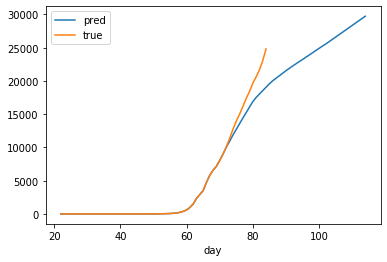

In [163]:
###############注意啊，这是什么模型的曲线?
#############这当然是确诊数目的曲线，但是确诊我训练了两个模型
########这是哪个模型？
#########这是我们拟合72天内的模型啊
##########可以看到72天内效果及其优秀，72天后呵呵
place = 'Iran'
df_interest_base = df_traintest9[df_traintest9['place_id']==place].reset_index(drop=True)
df_interest = copy.deepcopy(df_interest_base)
df_interest['ConfirmedCases'] = df_interest['ConfirmedCases'].astype(np.float)
df_interest['cases/day'] = df_interest['cases/day'].astype(np.float)
df_interest['fatal/day'] = df_interest['fatal/day'].astype(np.float)
df_interest['Fatalities'] = df_interest['Fatalities'].astype(np.float)
df_interest['cases/day'][df_interest['day']>=72] = -1
df_interest['fatal/day'][df_interest['day']>=72] = -1
len_known = (df_interest['cases/day']!=-1).sum()
len_unknown = (df_interest['cases/day']==-1).sum()
print("len train: {}, len prediction: {}".format(len_known, len_unknown))
X_valid = df_interest[col_var][df_interest['day']>=72]
X_valid2 = df_interest[col_var2][df_interest['day']>=72]
pred_f =  np.exp(model.predict(X_valid))-1
pred_c = np.exp(model2.predict(X_valid2))-1
df_interest['fatal/day'][df_interest['day']>=72] = pred_f.clip(0, 1e10)
df_interest['cases/day'][df_interest['day']>=72] = pred_c.clip(0, 1e10)
df_interest['Fatalities'] = np.cumsum(df_interest['fatal/day'].values)
df_interest['ConfirmedCases'] = np.cumsum(df_interest['cases/day'].values)
for j in range(len_unknown): # use predicted cases and fatal for next days' prediction
    X_valid = df_interest[col_var].iloc[j+len_known]
    X_valid2 = df_interest[col_var2].iloc[j+len_known]
    pred_f = model.predict(X_valid)
    pred_c = model2.predict(X_valid2)
    pred_c = (np.exp(pred_c)-1).clip(0, 1e10)
    pred_f = (np.exp(pred_f)-1).clip(0, 1e10)
    df_interest['fatal/day'][j+len_known] = pred_f
    df_interest['cases/day'][j+len_known] = pred_c
    df_interest['Fatalities'][j+len_known] = df_interest['Fatalities'][j+len_known-1] + pred_f
    df_interest['ConfirmedCases'][j+len_known] = df_interest['ConfirmedCases'][j+len_known-1] + pred_c
    df_interest = df_interest.drop([
        'cases/day-(1-1)', 'cases/day-(1-7)', 'cases/day-(8-14)', 'cases/day-(15-21)', 
        'fatal/day-(1-1)', 'fatal/day-(1-7)', 'fatal/day-(8-14)', 'fatal/day-(15-21)', 
        'days_since_1cases', 'days_since_10cases', 'days_since_100cases',
        'days_since_1fatal', 'days_since_10fatal', 'days_since_100fatal',], axis=1)
    df_interest = do_aggregations(df_interest.reset_index(drop=True))
# visualize
tmp = df_interest['cases/day'].values
tmp = np.cumsum(tmp)
sns.lineplot(x=df_interest_base['day'], y=tmp, label='pred')
tmp = df_traintest8['ConfirmedCases'][(df_traintest8['place_id']==place)& (pd.isna(df_traintest8['ForecastId']))].values
print(len(tmp), tmp)
sns.lineplot(x=df_traintest8['day'][(df_traintest8['place_id']==place)& (pd.isna(df_traintest8['ForecastId']))].values,
             y=tmp, label='true')
print(place)
plt.show()

In [165]:
last_day_train = df_traintest8['day'][pd.isna(df_traintest8['ForecastId'])].max()
print(last_day_train)
df_tmp = df_traintest8[
    (pd.isna(df_traintest8['ForecastId'])) |
    ((df_traintest8['day']>last_day_train) & (pd.isna(df_traintest8['ForecastId'])==False))].reset_index(drop=True)
df_tmp = df_tmp.drop([
    'cases/day-(1-1)', 'cases/day-(1-7)', 'cases/day-(8-14)', 'cases/day-(15-21)', 
    'fatal/day-(1-1)', 'fatal/day-(1-7)', 'fatal/day-(8-14)', 'fatal/day-(15-21)',
    'days_since_1cases', 'days_since_10cases', 'days_since_100cases',
    'days_since_1fatal', 'days_since_10fatal', 'days_since_100fatal',
                               ],  axis=1)
df_traintest10 = []
############################再次聚合，记不记得，我们又动了数据了
for i, place in enumerate(places[:]):
    df_tmp2 = df_tmp[df_tmp['place_id']==place].reset_index(drop=True)
    df_tmp2 = do_aggregations(df_tmp2)
    df_traintest10.append(df_tmp2)
df_traintest10 = pd.concat(df_traintest10).reset_index(drop=True)
df_traintest10[df_traintest10['day']>last_day_train-5].head(10) 

84


F:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
F:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,ForecastId,place_id,day,cases/day,fatal/day,SmokingRate,Country,Gross_domestic_product__constant_prices,Gross_domestic_product__current_prices,Gross_domestic_product__deflator,Gross_domestic_product_per_capita__constant_prices,Gross_domestic_product_per_capita__current_prices,Output_gap_in_percent_of_potential_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__valuation_of_country_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__per_capita_GDP,Gross_domestic_product_based_on_purchasing_power_parity__PPP__share_of_world_total,Implied_PPP_conversion_rate,Total_investment,Gross_national_savings,Inflation__average_consumer_prices,Inflation__end_of_period_consumer_prices,Six_month_London_interbank_offered_rate__LIBOR_,Volume_of_imports_of_goods_and_services,Volume_of_Imports_of_goods,Volume_of_exports_of_goods_and_services,Volume_of_exports_of_goods,Unemployment_rate,Employment,Population,General_government_revenue,General_government_total_expenditure,General_government_net_lending_borrowing,General_government_structural_balance,General_government_primary_net_lending_borrowing,General_government_net_debt,General_government_gross_debt,Gross_domestic_product_corresponding_to_fiscal_year__current_prices,Current_account_balance,LifeExpectancy,pop,density,medianage,urbanpop,quarantine,schools,hospibed,smokers,sex0,sex14,sex25,sex54,sex64,sex65plus,sexratio,lung,femalelung,malelung,id,Country/Region_le,Province/State_le,cases/day-(1-1),cases/day-(1-7),cases/day-(8-14),cases/day-(15-21),fatal/day-(1-1),fatal/day-(1-7),fatal/day-(8-14),fatal/day-(15-21),days_since_1cases,days_since_10cases,days_since_100cases,days_since_1fatal,days_since_10fatal,days_since_100fatal
58,59.0,nan,Afghanistan,33.0,65.0,2020-03-20,24.0,0.0,NaN,Afghanistan,80,2.000000e+00,0.000000e+00,20.475517,Afghanistan,528.154,1692.57,320.469,14300.19,45827.64,NaN,75.87,2054.23,0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,1692.57,0.425,64.5,38928346.0,60.0,18.0,25.0,NaN,NaN,0.5,NaN,1.05,1.03,1.03,1.03,0.97,0.85,1.03,37.62,36.31,39.33,58,16,0,0.000000e+00,2.142857e+00,0.857143,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,25,6,0,0,0,0
59,60.0,nan,Afghanistan,33.0,65.0,2020-03-21,24.0,0.0,NaN,Afghanistan,81,0.000000e+00,0.000000e+00,20.475517,Afghanistan,528.154,1692.57,320.469,14300.19,45827.64,NaN,75.87,2054.23,0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,1692.57,0.425,64.5,38928346.0,60.0,18.0,25.0,NaN,NaN,0.5,NaN,1.05,1.03,1.03,1.03,0.97,0.85,1.03,37.62,36.31,39.33,59,16,0,2.000000e+00,2.428571e+00,0.857143,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,26,7,0,0,0,0
60,61.0,nan,Afghanistan,33.0,65.0,2020-03-22,40.0,1.0,NaN,Afghanistan,82,1.600000e+01,1.000000e+00,20.475517,Afghanistan,528.154,1692.57,320.469,14300.19,45827.64,NaN,75.87,2054.23,0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,1692.57,0.425,64.5,38928346.0,60.0,18.0,25.0,NaN,NaN,0.5,NaN,1.05,1.03,1.03,1.03,0.97,0.85,1.03,37.62,36.31,39.33,60,16,0,0.000000e+00,1.857143e+00,1.428571,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,27,8,0,0,0,0
61,62.0,nan,Afghanistan,33.0,65.0,2020-03-23,40.0,1.0,NaN,Afghanistan,83,0.000000e+00,0.000000e+00,20.475517,Afghanistan,528.154,1692.57,320.469,14300.19,45827.64,NaN,75.87,2054.23,0.053,22.309,18.346,20.174,124.809,131.29,NaN,3.559,2.773,13.252,17.026,NaN,NaN,36.933,469.79,467.62,2.17,NaN,2.532,NaN,101.669,1692.57,0.425,64.5,38928346.0,60.0,18.0,25.0,NaN,NaN,0.5,NaN,1.05,1.03,1.03,1.03,0.97,0.85,1.03,37.62,36.31,39.33,61,16,0,1.600000e+01,3.428571e+00,1.714286,0.428571,1.000000e+00,1.428571e-01,0.0,0.0,28,9,0,1,0,0
62,63.0,nan,Afghanistan,33.0,65.0,2020-03-24,74.0,1.0,NaN,Afghanistan,84,3.400000e+01,0.000000e+00,20.475517,Afghanistan,528.

In [167]:
###################和前面一样啊，只是预测的是死亡人数

F:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
F:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
F:\Anaconda\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
F:\Anaconda\lib\site-packages\ipykernel_launcher.py:19: S

len train: 50, len prediction: 43
63 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    2.    2.    4.    5.    8.   12.   16.   19.
   26.   34.   43.   54.   66.   77.   92.  107.  124.  145.  194.  237.
  291.  354.  429.  514.  611.  724.  853.  988. 1135. 1284. 1433. 1556.
 1685. 1812. 1934.]
Iran


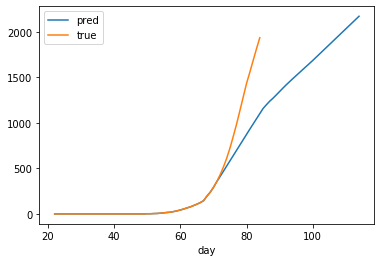

In [166]:
place = places[np.random.randint(len(places))]
place = "Iran"
df_interest_base = df_traintest9[df_traintest9['place_id']==place].reset_index(drop=True)
df_interest = copy.deepcopy(df_interest_base)
df_interest['ConfirmedCases'] = df_interest['ConfirmedCases'].astype(np.float)
df_interest['cases/day'] = df_interest['cases/day'].astype(np.float)
df_interest['fatal/day'] = df_interest['fatal/day'].astype(np.float)
df_interest['Fatalities'] = df_interest['Fatalities'].astype(np.float)
df_interest['cases/day'][df_interest['day']>=72] = -1
df_interest['fatal/day'][df_interest['day']>=72] = -1
len_known = (df_interest['cases/day']!=-1).sum()
len_unknown = (df_interest['cases/day']==-1).sum()
print("len train: {}, len prediction: {}".format(len_known, len_unknown))
X_valid = df_interest[col_var][df_interest['day']>=72]
X_valid2 = df_interest[col_var2][df_interest['day']>=72]
pred_f =  np.exp(model.predict(X_valid))-1
pred_c = np.exp(model2.predict(X_valid2))-1
df_interest['fatal/day'][df_interest['day']>=72] = pred_f.clip(0, 1e10)
df_interest['cases/day'][df_interest['day']>=72] = pred_c.clip(0, 1e10)
df_interest['Fatalities'] = np.cumsum(df_interest['fatal/day'].values)
df_interest['ConfirmedCases'] = np.cumsum(df_interest['cases/day'].values)
for j in range(len_unknown): # use predicted cases and fatal for next days' prediction
    X_valid = df_interest[col_var].iloc[j+len_known]
    X_valid2 = df_interest[col_var2].iloc[j+len_known]
    pred_f = model.predict(X_valid)
    pred_c = model2.predict(X_valid2)
    pred_c = (np.exp(pred_c)-1).clip(0, 1e10)
    pred_f = (np.exp(pred_f)-1).clip(0, 1e10)
    df_interest['fatal/day'][j+len_known] = pred_f
    df_interest['cases/day'][j+len_known] = pred_c
    df_interest['Fatalities'][j+len_known] = df_interest['Fatalities'][j+len_known-1] + pred_f
    df_interest['ConfirmedCases'][j+len_known] = df_interest['ConfirmedCases'][j+len_known-1] + pred_c
    df_interest = df_interest.drop([
    'cases/day-(1-1)', 'cases/day-(1-7)', 'cases/day-(8-14)', 'cases/day-(15-21)', 
    'fatal/day-(1-1)', 'fatal/day-(1-7)', 'fatal/day-(8-14)', 'fatal/day-(15-21)',
    'days_since_1cases', 'days_since_10cases', 'days_since_100cases',
    'days_since_1fatal', 'days_since_10fatal', 'days_since_100fatal',
                                   
                                   ],  axis=1)
    df_interest = do_aggregations(df_interest.reset_index(drop=True))

# visualize
tmp = df_interest['fatal/day'].values
tmp = np.cumsum(tmp)
sns.lineplot(x=df_interest_base['day'], y=tmp, label='pred')
tmp = df_traintest8['Fatalities'][(df_traintest8['place_id']==place)& (pd.isna(df_traintest8['ForecastId']))].values
print(len(tmp), tmp)
sns.lineplot(x=df_traintest8['day'][(df_traintest8['place_id']==place)& (pd.isna(df_traintest8['ForecastId']))].values,
             y=tmp, label='true')
print(place)
plt.show()

In [175]:
#####################来看看我们最终的模型
###################还是伊朗兄弟

F:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
F:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
F:\Anaconda\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
F:\Anaconda\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set 

len train: 63, len prediction: 30
63 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 5.0000e+00
 1.8000e+01 2.8000e+01 4.3000e+01 6.1000e+01 9.5000e+01 1.3900e+02
 2.4500e+02 3.8800e+02 5.9300e+02 9.7800e+02 1.5010e+03 2.3360e+03
 2.9220e+03 3.5130e+03 4.7470e+03 5.8230e+03 6.5660e+03 7.1610e+03
 8.0420e+03 9.0000e+03 1.0075e+04 1.1364e+04 1.2729e+04 1.3938e+04
 1.4991e+04 1.6169e+04 1.7361e+04 1.8407e+04 1.9644e+04 2.0610e+04
 2.1638e+04 2.3049e+04 2.4811e+04]
Iran


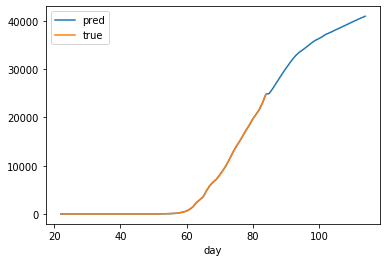

In [176]:
place = 'Iran'
df_interest_base = df_traintest10[df_traintest10['place_id']==place].reset_index(drop=True)
df_interest = copy.deepcopy(df_interest_base)
df_interest['ConfirmedCases'] = df_interest['ConfirmedCases'].astype(np.float)
df_interest['cases/day'] = df_interest['cases/day'].astype(np.float)
df_interest['fatal/day'] = df_interest['fatal/day'].astype(np.float)
df_interest['Fatalities'] = df_interest['Fatalities'].astype(np.float)
df_interest['cases/day'][df_interest['day']>last_day_train] = -1
df_interest['fatal/day'][df_interest['day']>last_day_train] = -1
len_known = (df_interest['cases/day']!=-1).sum()
len_unknown = (df_interest['cases/day']==-1).sum()
print("len train: {}, len prediction: {}".format(len_known, len_unknown))
X_valid = df_interest[col_var][df_interest['day']>84]
X_valid2 = df_interest[col_var2][df_interest['day']>84]
pred_f =  np.exp(model.predict(X_valid))-1
pred_c = np.exp(model2.predict(X_valid2))-1
df_interest['fatal/day'][df_interest['day']>last_day_train] = pred_f.clip(0, 1e10)
df_interest['cases/day'][df_interest['day']>last_day_train] = pred_c.clip(0, 1e10)
df_interest['Fatalities'] = np.cumsum(df_interest['fatal/day'].values)
df_interest['ConfirmedCases'] = np.cumsum(df_interest['cases/day'].values)
for j in range(len_unknown): # use predicted cases and fatal for next days' prediction
    X_valid = df_interest[col_var].iloc[j+len_known]
    X_valid2 = df_interest[col_var2].iloc[j+len_known]
    pred_f = model_pri.predict(X_valid)
    pred_c = model2_pri.predict(X_valid2)
    pred_c = (np.exp(pred_c)-1).clip(0, 1e10)
    pred_f = (np.exp(pred_f)-1).clip(0, 1e10)
    df_interest['fatal/day'][j+len_known] = pred_f
    df_interest['cases/day'][j+len_known] = pred_c
    df_interest['Fatalities'][j+len_known] = df_interest['Fatalities'][j+len_known-1] + pred_f
    df_interest['ConfirmedCases'][j+len_known] = df_interest['ConfirmedCases'][j+len_known-1] + pred_c
    df_interest = df_interest.drop([
         'cases/day-(1-1)', 'cases/day-(1-7)', 'cases/day-(8-14)', 'cases/day-(15-21)', 
    'fatal/day-(1-1)', 'fatal/day-(1-7)', 'fatal/day-(8-14)', 'fatal/day-(15-21)',
    'days_since_1cases', 'days_since_10cases', 'days_since_100cases',
    'days_since_1fatal', 'days_since_10fatal', 'days_since_100fatal',],  axis=1)
    df_interest = do_aggregations(df_interest.reset_index(drop=True))

# visualize
tmp = df_interest['cases/day'].values
tmp = np.cumsum(tmp)
sns.lineplot(x=df_interest_base['day'], y=tmp, label='pred')
tmp = df_traintest10['ConfirmedCases'][(df_traintest10['place_id']==place)& (pd.isna(df_traintest10['ForecastId']))].values
print(len(tmp), tmp)
sns.lineplot(x=df_traintest10['day'][(df_traintest10['place_id']==place)& (pd.isna(df_traintest10['ForecastId']))].values,
             y=tmp, label='true')
print(place)
plt.show()

In [177]:
##################还是伊朗兄弟

F:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
F:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
F:\Anaconda\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
F:\Anaconda\lib\site-packag

len train: 63, len prediction: 30
63 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Honduras


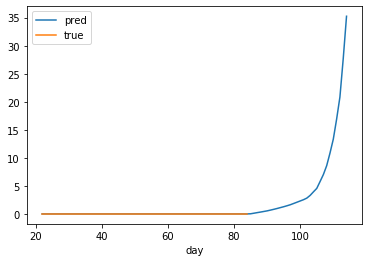

In [178]:
place = 'Bhutan'
place = places[np.random.randint(len(places))]
# place = 'Iran'
df_interest_base = df_traintest10[df_traintest10['place_id']==place].reset_index(drop=True)
df_interest = copy.deepcopy(df_interest_base)
df_interest['ConfirmedCases'] = df_interest['ConfirmedCases'].astype(np.float)
df_interest['cases/day'] = df_interest['cases/day'].astype(np.float)
df_interest['fatal/day'] = df_interest['fatal/day'].astype(np.float)
df_interest['Fatalities'] = df_interest['Fatalities'].astype(np.float)
df_interest['cases/day'][df_interest['day']>last_day_train] = -1
df_interest['fatal/day'][df_interest['day']>last_day_train] = -1
###################标记训练与预测数据
len_known = (df_interest['cases/day']!=-1).sum()
len_unknown = (df_interest['cases/day']==-1).sum()
print("len train: {}, len prediction: {}".format(len_known, len_unknown))
X_valid = df_interest[col_var][df_interest['day']>84]
X_valid2 = df_interest[col_var2][df_interest['day']>84]
pred_f =  np.exp(model.predict(X_valid))-1
pred_c = np.exp(model2.predict(X_valid2))-1
df_interest['fatal/day'][df_interest['day']>last_day_train] = pred_f.clip(0, 1e10)
df_interest['cases/day'][df_interest['day']>last_day_train] = pred_c.clip(0, 1e10)
########累计确诊是每日确诊相加
df_interest['Fatalities'] = np.cumsum(df_interest['fatal/day'].values)
df_interest['ConfirmedCases'] = np.cumsum(df_interest['cases/day'].values)
for j in range(len_unknown): # use predicted cases and fatal for next days' prediction
    X_valid = df_interest[col_var].iloc[j+len_known]
    X_valid2 = df_interest[col_var2].iloc[j+len_known]
    pred_f = model_pri.predict(X_valid)
    pred_c = model2_pri.predict(X_valid2)
    pred_c = (np.exp(pred_c)-1).clip(0, 1e10)
    pred_f = (np.exp(pred_f)-1).clip(0, 1e10)
    df_interest['fatal/day'][j+len_known] = pred_f
    df_interest['cases/day'][j+len_known] = pred_c
    df_interest['Fatalities'][j+len_known] = df_interest['Fatalities'][j+len_known-1] + pred_f
    df_interest['ConfirmedCases'][j+len_known] = df_interest['ConfirmedCases'][j+len_known-1] + pred_c
    df_interest = df_interest.drop([
        'cases/day-(1-1)', 'cases/day-(1-7)', 'cases/day-(8-14)', 'cases/day-(15-21)', 
        'fatal/day-(1-1)', 'fatal/day-(1-7)', 'fatal/day-(8-14)', 'fatal/day-(15-21)', 
        'days_since_1cases', 'days_since_10cases', 'days_since_100cases',
        'days_since_1fatal', 'days_since_10fatal', 'days_since_100fatal',
                                   
                                   ],  axis=1)
    df_interest = do_aggregations(df_interest.reset_index(drop=True))

# visualize
tmp = df_interest['fatal/day'].values
tmp = np.cumsum(tmp)
sns.lineplot(x=df_interest_base['day'], y=tmp, label='pred')
tmp = df_traintest10['Fatalities'][(df_traintest10['place_id']==place)& (pd.isna(df_traintest10['ForecastId']))].values
print(len(tmp), tmp)
sns.lineplot(x=df_traintest10['day'][(df_traintest10['place_id']==place)& (pd.isna(df_traintest10['ForecastId']))].values,
             y=tmp, label='true')
print(place)
plt.show()

In [179]:
###################训练集合当然拟合好了
################我们把全部数据给了决策树啊
#################之后呢？不知道，给kaggle判个分吧

In [180]:
##########################就这样吧，每个人都跑一遍然后提交，提交格式参考其他选手，或者日本友人

In [ ]:
#################下面是之前的老笔记

In [ ]:
####################提交过程，参考其他选手，需要维持原来的格式

In [ ]:
#################下面是之前的老笔记

In [153]:
###############每个人都提交一次

In [ ]:
#########################之后不用看了,不需要

In [ ]:
#################################之后是向kaggle提交的过程

In [ ]:
# predict test data in public
day_before_public = 71
df_preds = []
for i, place in enumerate(places[:]):
#     if place!='Japan' and place!='Afghanistan' :continue
    df_interest = copy.deepcopy(df_traintest9[df_traintest9['place_id']==place].reset_index(drop=True))
    df_interest['cases/day'][(pd.isna(df_interest['ForecastId']))==False] = -1
    df_interest['fatal/day'][(pd.isna(df_interest['ForecastId']))==False] = -1
    len_known = (df_interest['day']<=day_before_public).sum()
    len_unknown = (day_before_public<df_interest['day']).sum()
    for j in range(len_unknown): # use predicted cases and fatal for next days' prediction
        X_valid = df_interest[col_var].iloc[j+len_known]
        X_valid2 = df_interest[col_var2].iloc[j+len_known]
        pred_f = model.predict(X_valid)
        pred_c = model2.predict(X_valid2)
        pred_c = (np.exp(pred_c)-1).clip(0, 1e10)
        pred_f = (np.exp(pred_f)-1).clip(0, 1e10)
        df_interest['fatal/day'][j+len_known] = pred_f
        df_interest['cases/day'][j+len_known] = pred_c
        df_interest['Fatalities'][j+len_known] = df_interest['Fatalities'][j+len_known-1] + pred_f
        df_interest['ConfirmedCases'][j+len_known] = df_interest['ConfirmedCases'][j+len_known-1] + pred_c
        df_interest = df_interest.drop([
            'cases/day-(1-1)', 'cases/day-(1-7)', 'cases/day-(8-14)', 'cases/day-(15-21)', 
            'fatal/day-(1-1)', 'fatal/day-(1-7)', 'fatal/day-(8-14)', 'fatal/day-(15-21)',
            'days_since_1cases', 'days_since_10cases', 'days_since_100cases',
            'days_since_1fatal', 'days_since_10fatal', 'days_since_100fatal',
                    ],  axis=1)
        df_interest = do_aggregations(df_interest)
    if (i+1)%10==0:
        print("{:3d}/{}  {}, len known: {}, len unknown: {}".format(i+1, len(places), place, len_known, len_unknown), df_interest.shape)
    df_interest['fatal_pred'] = np.cumsum(df_interest['fatal/day'].values)
    df_interest['cases_pred'] = np.cumsum(df_interest['cases/day'].values)
    df_preds.append(df_interest)

In [ ]:
df_preds= pd.concat(df_preds)
df_preds = df_preds.sort_values('day')
col_tmp = ['place_id', 'ForecastId', 'day', 'cases/day', 'cases_pred', 'fatal/day', 'fatal_pred',]
df_preds[col_tmp][(df_preds['place_id']=='Afghanistan') & (df_preds['day']>75)].head(10)

In [ ]:
df_preds.to_csv("submission.csv", index=None)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Check the predictions of of Cases Public
place = 'Bhutan'
# place = places[np.random.randint(len(places))]
# place = 'Iran'
df_interest_base = df_traintest9[df_traintest9['place_id']==place].reset_index(drop=True)
print(df_traintest9[df_traintest9['place_id']==place])
df_interest = copy.deepcopy(df_interest_base)
df_interest['ConfirmedCases'] = df_interest['ConfirmedCases'].astype(np.float)
df_interest['cases/day'] = df_interest['cases/day'].astype(np.float)
df_interest['fatal/day'] = df_interest['fatal/day'].astype(np.float)
df_interest['Fatalities'] = df_interest['Fatalities'].astype(np.float)
df_interest['cases/day'][df_interest['day']>=72] = -1
df_interest['fatal/day'][df_interest['day']>=72] = -1
len_known = (df_interest['cases/day']!=-1).sum()
len_unknown = (df_interest['cases/day']==-1).sum()
print("len train: {}, len prediction: {}".format(len_known, len_unknown))
X_valid = df_interest[col_var][df_interest['day']>=72]
X_valid2 = df_interest[col_var2][df_interest['day']>=72]
pred_f =  np.exp(model.predict(X_valid))-1
pred_c = np.exp(model2.predict(X_valid2))-1
df_interest['fatal/day'][df_interest['day']>=72] = pred_f.clip(0, 1e10)
df_interest['cases/day'][df_interest['day']>=72] = pred_c.clip(0, 1e10)
df_interest['Fatalities'] = np.cumsum(df_interest['fatal/day'].values)
df_interest['ConfirmedCases'] = np.cumsum(df_interest['cases/day'].values)
for j in range(len_unknown): # use predicted cases and fatal for next days' prediction
    X_valid = df_interest[col_var].iloc[j+len_known]
    X_valid2 = df_interest[col_var2].iloc[j+len_known]
    pred_f = model.predict(X_valid)
    pred_c = model2.predict(X_valid2)
    pred_c = (np.exp(pred_c)-1).clip(0, 1e10)
    pred_f = (np.exp(pred_f)-1).clip(0, 1e10)
    df_interest['fatal/day'][j+len_known] = pred_f
    df_interest['cases/day'][j+len_known] = pred_c
    df_interest['Fatalities'][j+len_known] = df_interest['Fatalities'][j+len_known-1] + pred_f
    df_interest['ConfirmedCases'][j+len_known] = df_interest['ConfirmedCases'][j+len_known-1] + pred_c
    df_interest = df_interest.drop([
        'cases/day_(1-1)', 'cases/day_(1-7)', 'cases/day_(8-14)', 'cases/day_(15-21)', 
        'fatal/day_(1-1)', 'fatal/day_(1-7)', 'fatal/day_(8-14)', 'fatal/day_(15-21)', 
        'days_since_1cases', 'days_since_10cases', 'days_since_100cases',
        'days_since_1fatal', 'days_since_10fatal', 'days_since_100fatal',
                                   
                                   ],  axis=1)
    df_interest = do_aggregations(df_interest.reset_index(drop=True))

# visualize
tmp = df_interest['cases/day'].values
print(tmp)
tmp = np.cumsum(tmp)
# print(tmp)
sns.lineplot(x=df_interest_base['day'], y=tmp, label='pred')
tmp = df_traintest8['ConfirmedCases'][(df_traintest8['place_id']==place)& (pd.isna(df_traintest8['ForecastId']))].values
print(len(tmp), tmp)
sns.lineplot(x=df_traintest8['day'][(df_traintest8['place_id']==place)& (pd.isna(df_traintest8['ForecastId']))].values,
             y=tmp, label='true')
print(place)
plt.show()

In [ ]:
# Check the predictions of of Cases Public
place = 'Bhutan'
# place = places[np.random.randint(len(places))]
# place = 'Iran'
df_interest_base = df_traintest9[df_traintest9['place_id']==place].reset_index(drop=True)
print(df_traintest9[df_traintest9['place_id']==place])
df_interest = copy.deepcopy(df_interest_base)
df_interest['ConfirmedCases'] = df_interest['ConfirmedCases'].astype(np.float)
df_interest['cases/day'] = df_interest['cases/day'].astype(np.float)
df_interest['fatal/day'] = df_interest['fatal/day'].astype(np.float)
df_interest['Fatalities'] = df_interest['Fatalities'].astype(np.float)
df_interest['cases/day'][df_interest['day']>=72] = -1
df_interest['fatal/day'][df_interest['day']>=72] = -1
len_known = (df_interest['cases/day']!=-1).sum()
len_unknown = (df_interest['cases/day']==-1).sum()
print("len train: {}, len prediction: {}".format(len_known, len_unknown))
X_valid = df_interest[col_var][df_interest['day']>=72]
X_valid2 = df_interest[col_var2][df_interest['day']>=72]
pred_f =  np.exp(model.predict(X_valid))-1
pred_c = np.exp(model2.predict(X_valid2))-1
df_interest['fatal/day'][df_interest['day']>=72] = pred_f.clip(0, 1e10)
df_interest['cases/day'][df_interest['day']>=72] = pred_c.clip(0, 1e10)
df_interest['Fatalities'] = np.cumsum(df_interest['fatal/day'].values)
df_interest['ConfirmedCases'] = np.cumsum(df_interest['cases/day'].values)
for j in range(len_unknown): # use predicted cases and fatal for next days' prediction
    X_valid = df_interest[col_var].iloc[j+len_known]
    X_valid2 = df_interest[col_var2].iloc[j+len_known]
    pred_f = model.predict(X_valid)
    pred_c = model2.predict(X_valid2)
    pred_c = (np.exp(pred_c)-1).clip(0, 1e10)
    pred_f = (np.exp(pred_f)-1).clip(0, 1e10)
    df_interest['fatal/day'][j+len_known] = pred_f
    df_interest['cases/day'][j+len_known] = pred_c
    df_interest['Fatalities'][j+len_known] = df_interest['Fatalities'][j+len_known-1] + pred_f
    df_interest['ConfirmedCases'][j+len_known] = df_interest['ConfirmedCases'][j+len_known-1] + pred_c
    df_interest = df_interest.drop([
        'cases/day_(1-1)', 'cases/day_(1-7)', 'cases/day_(8-14)', 'cases/day_(15-21)', 
        'fatal/day_(1-1)', 'fatal/day_(1-7)', 'fatal/day_(8-14)', 'fatal/day_(15-21)', 
        'days_since_1cases', 'days_since_10cases', 'days_since_100cases',
        'days_since_1fatal', 'days_since_10fatal', 'days_since_100fatal',
                                   
                                   ],  axis=1)
    df_interest = do_aggregations(df_interest.reset_index(drop=True))

# visualize
tmp = df_interest['cases/day'].values
print(tmp)
tmp = np.cumsum(tmp)
# print(tmp)
sns.lineplot(x=df_interest_base['day'], y=tmp, label='pred')
tmp = df_traintest8['ConfirmedCases'][(df_traintest8['place_id']==place)& (pd.isna(df_traintest8['ForecastId']))].values
print(len(tmp), tmp)
sns.lineplot(x=df_traintest8['day'][(df_traintest8['place_id']==place)& (pd.isna(df_traintest8['ForecastId']))].values,
             y=tmp, label='true')
print(place)
plt.show()

In [ ]:
# Check the predictions of of Cases Public
place = 'Afghanistan'
# place = places[np.random.randint(len(places))]
# place = 'Iran'
df_interest_base = df_traintest9[df_traintest9['place_id']==place].reset_index(drop=True)
df_interest = copy.deepcopy(df_interest_base)
df_interest['ConfirmedCases'] = df_interest['ConfirmedCases'].astype(np.float)
df_interest['cases/day'] = df_interest['cases/day'].astype(np.float)
df_interest['fatal/day'] = df_interest['fatal/day'].astype(np.float)
df_interest['Fatalities'] = df_interest['Fatalities'].astype(np.float)
df_interest['cases/day'][df_interest['day']>=72] = -1
df_interest['fatal/day'][df_interest['day']>=72] = -1
len_known = (df_interest['cases/day']!=-1).sum()
len_unknown = (df_interest['cases/day']==-1).sum()
print("len train: {}, len prediction: {}".format(len_known, len_unknown))
X_valid = df_interest[col_var][df_interest['day']>=72]
X_valid2 = df_interest[col_var2][df_interest['day']>=72]
pred_f =  np.exp(model.predict(X_valid))-1
pred_c = np.exp(model2.predict(X_valid2))-1
df_interest['fatal/day'][df_interest['day']>=72] = pred_f.clip(0, 1e10)
df_interest['cases/day'][df_interest['day']>=72] = pred_c.clip(0, 1e10)
df_interest['Fatalities'] = np.cumsum(df_interest['fatal/day'].values)
df_interest['ConfirmedCases'] = np.cumsum(df_interest['cases/day'].values)
for j in range(len_unknown): # use predicted cases and fatal for next days' prediction
    X_valid = df_interest[col_var].iloc[j+len_known]
    X_valid2 = df_interest[col_var2].iloc[j+len_known]
    pred_f = model.predict(X_valid)
    pred_c = model2.predict(X_valid2)
    pred_c = (np.exp(pred_c)-1).clip(0, 1e10)
    pred_f = (np.exp(pred_f)-1).clip(0, 1e10)
    df_interest['fatal/day'][j+len_known] = pred_f
    df_interest['cases/day'][j+len_known] = pred_c
    df_interest['Fatalities'][j+len_known] = df_interest['Fatalities'][j+len_known-1] + pred_f
    df_interest['ConfirmedCases'][j+len_known] = df_interest['ConfirmedCases'][j+len_known-1] + pred_c
    df_interest = df_interest.drop([
        'cases/day-(1-1)', 'cases/day-(1-7)', 'cases/day-(8-14)', 'cases/day-(15-21)', 
        'fatal/day-(1-1)', 'fatal/day-(1-7)', 'fatal/day-(8-14)', 'fatal/day-(15-21)',],  axis=1)
    df_interest = do_aggregations(df_interest.reset_index(drop=True))

# visualize
tmp = df_interest['cases/day'].values
tmp = np.cumsum(tmp)
sns.lineplot(x=df_interest_base['day'], y=tmp, label='pred')
tmp = df_traintest8['ConfirmedCases'][(df_traintest8['place_id']==place)& (pd.isna(df_traintest8['ForecastId']))].values
print(len(tmp), tmp)
sns.lineplot(x=df_traintest8['day'][(df_traintest8['place_id']==place)& (pd.isna(df_traintest8['ForecastId']))].values,
             y=tmp, label='true')
print(place)
plt.show()

In [ ]:
col_target2 = 'cases/day'
col_var2 = [
    'Lat', 'Long',
#     'days_since_1cases', 
    'days_since_10cases', #selected
#     'days_since_100cases',
#     'days_since_1fatal', 
#     'days_since_10fatal',
#     'days_since_100fatal',
#     'days_since_1recov',
#     'days_since_10recov', 'days_since_100recov', 
    'cases/day-(1-1)', 
    'cases/day-(1-7)', 
    'cases/day-(8-14)',  
    'cases/day-(15-21)', 
    
#     'fatal/day_(1-1)', 
#     'fatal/day_(1-7)', 
#     'fatal/day_(8-14)', 
#     'fatal/day_(15-21)', 
#     'recov/day_(1-1)', 'recov/day_(1-7)', 
#     'recov/day_(8-14)',  'recov/day_(15-21)',
#     'active_(1-1)', 
#     'active_(1-7)', 
#     'active_(8-14)',  'active_(15-21)', 
#     'SmokingRate',
#     'Gross_domestic_product__constant_prices',
#     'Gross_domestic_product__current_prices',
#     'Gross_domestic_product__deflator',
#     'Gross_domestic_product_per_capita__constant_prices',
#     'Gross_domestic_product_per_capita__current_prices',
#     'Output_gap_in_percent_of_potential_GDP',
#     'Gross_domestic_product_based_on_purchasing_power_parity__PPP__valuation_of_country_GDP',
#     'Gross_domestic_product_based_on_purchasing_power_parity__PPP__per_capita_GDP',
#     'Gross_domestic_product_based_on_purchasing_power_parity__PPP__share_of_world_total',
#     'Implied_PPP_conversion_rate', 'Total_investment',
#     'Gross_national_savings', 'Inflation__average_consumer_prices',
#     'Inflation__end_of_period_consumer_prices',
#     'Six_month_London_interbank_offered_rate__LIBOR_',
#     'Volume_of_imports_of_goods_and_services', 'Volume_of_Imports_of_goods',
#     'Volume_of_exports_of_goods_and_services', 'Volume_of_exports_of_goods',
#     'Unemployment_rate', 
#     'Employment', 
#     'Population',
#     'General_government_revenue', 'General_government_total_expenditure',
#     'General_government_net_lending_borrowing',
#     'General_government_structural_balance',
#     'General_government_primary_net_lending_borrowing',
#     'General_government_net_debt', 'General_government_gross_debt',
#     'Gross_domestic_product_corresponding_to_fiscal_year__current_prices',
#     'Current_account_balance', 
#     'LifeExpectancy',
#     'pop',
#     'density', 
#     'medianage', 
#     'urbanpop', 
#     'hospibed', 'smokers', 
]
col_cat = []
df_train = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']<61)]
df_valid = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']>=61) & (df_traintest8['day']<72)]
# df_valid = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']>=61)]
df_test = df_traintest8[pd.isna(df_traintest8['ForecastId'])==False]
X_train = df_train[col_var2]
X_valid = df_valid[col_var2]
y_train = np.log(df_train[col_target2].values.clip(0, 1e10)+1)
y_valid = np.log(df_valid[col_target2].values.clip(0, 1e10)+1)
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=col_cat)
valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=col_cat)
model2 = lgb.train(params, train_data, num_round, valid_sets=[train_data, valid_data],
                  verbose_eval=100,
                  early_stopping_rounds=150,)
best_itr = model2.best_iteration

In [ ]:
y_true = df_valid['cases/day'].values
y_pred = np.exp(model2.predict(X_valid))-1
score = calc_score(y_true, y_pred)
print("{:.6f}".format(score))            ##################这就不是很好的结果了

In [ ]:
#####################同理，最后在整个集合上观察结果

In [ ]:
df_train = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']<72)]
df_valid = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']<72)]
# df_valid = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']>=61)]
df_test = df_traintest8[pd.isna(df_traintest8['ForecastId'])==False]
X_train = df_train[col_var2]
X_valid = df_valid[col_var2]
y_train = np.log(df_train[col_target2].values.clip(0, 1e10)+1)
y_valid = np.log(df_valid[col_target2].values.clip(0, 1e10)+1)
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=col_cat)
valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=col_cat)
model2 = lgb.train(params, train_data, best_itr, valid_sets=[train_data, valid_data],
                  verbose_eval=100,
                  early_stopping_rounds=150,)

In [ ]:
#################改变训练集测试集？为什么要改变？还要想想
#################为什么引入了之后的步骤啊，可能要结合下面数据可视化的部分才知道，都是和上面一样冗余的过程
#################大概的意思就是：改变训练集测试集数据的范围？因为有部分地区有足够多的日期数据

In [ ]:
# train model to predict fatalities/day
df_train = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']<72)]
df_valid = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']>=72)]
df_test = df_traintest8[pd.isna(df_traintest8['ForecastId'])==False]
X_train = df_train[col_var]
X_valid = df_valid[col_var]
y_train = np.log(df_train[col_target].values.clip(0, 1e10)+1)
y_valid = np.log(df_valid[col_target].values.clip(0, 1e10)+1)
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=col_cat)
valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=col_cat)
model_pri = lgb.train(params, train_data, num_round, valid_sets=[train_data, valid_data],
                  verbose_eval=100,
                  early_stopping_rounds=150,)
best_itr = model_pri.best_iteration

In [ ]:
df_train = df_traintest8[(pd.isna(df_traintest8['ForecastId']))]
df_valid = df_traintest8[(pd.isna(df_traintest8['ForecastId']))]
# df_valid = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']>=61)]
df_test = df_traintest8[pd.isna(df_traintest8['ForecastId'])==False]
X_train = df_train[col_var]
X_valid = df_valid[col_var]
y_train = np.log(df_train[col_target].values.clip(0, 1e10)+1)
y_valid = np.log(df_valid[col_target].values.clip(0, 1e10)+1)
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=col_cat)
valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=col_cat)
model_pri = lgb.train(params, train_data, best_itr, valid_sets=[train_data, valid_data],
                  verbose_eval=100,
                  early_stopping_rounds=150,)

In [ ]:
# train model to predict fatalities/day
df_train = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']<72)]
df_valid = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']>=72)]
# df_valid = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']>=61)]
df_test = df_traintest8[pd.isna(df_traintest8['ForecastId'])==False]
X_train = df_train[col_var2]
X_valid = df_valid[col_var2]
y_train = np.log(df_train[col_target2].values.clip(0, 1e10)+1)
y_valid = np.log(df_valid[col_target2].values.clip(0, 1e10)+1)
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=col_cat)
valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=col_cat)
model2_pri = lgb.train(params, train_data, num_round, valid_sets=[train_data, valid_data],
                  verbose_eval=100,
                  early_stopping_rounds=150,)
best_itr = model2_pri.best_iteration

In [ ]:
df_train = df_traintest8[(pd.isna(df_traintest8['ForecastId']))]
df_valid = df_traintest8[(pd.isna(df_traintest8['ForecastId']))]
# df_valid = df_traintest8[(pd.isna(df_traintest8['ForecastId'])) & (df_traintest8['day']>=61)]
df_test = df_traintest8[pd.isna(df_traintest8['ForecastId'])==False]
X_train = df_train[col_var2]
X_valid = df_valid[col_var2]
y_train = np.log(df_train[col_target2].values.clip(0, 1e10)+1)
y_valid = np.log(df_valid[col_target2].values.clip(0, 1e10)+1)
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=col_cat)
valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=col_cat)
model2_pri = lgb.train(params, train_data, best_itr, valid_sets=[train_data, valid_data],
                  verbose_eval=100,
                  early_stopping_rounds=150,)
best_itr = model2_pri.best_iteration

In [ ]:
###############训练模型结束！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！去跑步了！！！！！！！！！
###############下面是可视化部分
###############将训练集中超过72天的数据完全抛弃，保留所有的测试集

In [ ]:
df_tmp = df_traintest8[(df_traintest8['day']<72) | (pd.isna(df_traintest8['ForecastId'])==False)].reset_index(drop=True)
#########################选取了一段较长的的日期，筛选了训练集中72天内测试数据以及所有的训练数据
###############################手动删除了之前聚合产生的特征
df_tmp = df_tmp.drop([
    'cases/day-(1-1)', 'cases/day-(1-7)', 'cases/day-(8-14)', 'cases/day-(15-21)', 
    'fatal/day-(1-1)', 'fatal/day-(1-7)', 'fatal/day-(8-14)', 'fatal/day-(15-21)',
    'days_since_1cases', 'days_since_10cases', 'days_since_100cases',
    'days_since_1fatal', 'days_since_10fatal', 'days_since_100fatal',
                               ],  axis=1)
df_traintest9 = []
###################因为手动调整了每个地区的日期范围，所以需要重新滚动聚合
for i, place in enumerate(places[:]):
    df_tmp2 = df_tmp[df_tmp['place_id']==place].reset_index(drop=True)
    df_tmp2 = do_aggregations(df_tmp2) 
    df_traintest9.append(df_tmp2)
df_traintest9 = pd.concat(df_traintest9).reset_index(drop=True)
df_traintest9[df_traintest9['day']>68].head()

In [ ]:
import seaborn as sns ###############熟悉的绘图库

In [ ]:
# Check the predictions of of Cases Public
place = 'Bhutan' ############世界上某个地方
# place = places[np.random.randint(len(places))]
# place = 'Iran'
df_interest_base = df_traintest9[df_traintest9['place_id']==place].reset_index(drop=True)
df_interest = copy.deepcopy(df_interest_base)   ###############筛选出选择预测的区域
#########################下面都是转换数据类型、
#########################把训练集与测试集中超过年第72天的数据（其实就是训练集合中超过72天的数据）
df_interest['ConfirmedCases'] = df_interest['ConfirmedCases'].astype(np.float)
df_interest['cases/day'] = df_interest['cases/day'].astype(np.float)
df_interest['fatal/day'] = df_interest['fatal/day'].astype(np.float)
df_interest['Fatalities'] = df_interest['Fatalities'].astype(np.float)
df_interest['cases/day'][df_interest['day']>=72] = -1
df_interest['fatal/day'][df_interest['day']>=72] = -1
len_known = (df_interest['cases/day']!=-1).sum()
len_unknown = (df_interest['cases/day']==-1).sum()
print("len train: {}, len prediction: {}".format(len_known, len_unknown))
###########################

X_valid = df_interest[col_var][df_interest['day']>=72]
X_valid2 = df_interest[col_var2][df_interest['day']>=72]
pred_f =  np.exp(model.predict(X_valid))-1
pred_c = np.exp(model2.predict(X_valid2))-1
df_interest['fatal/day'][df_interest['day']>=72] = pred_f.clip(0, 1e10)
df_interest['cases/day'][df_interest['day']>=72] = pred_c.clip(0, 1e10)
df_interest['Fatalities'] = np.cumsum(df_interest['fatal/day'].values)
df_interest['ConfirmedCases'] = np.cumsum(df_interest['cases/day'].values)
for j in range(len_unknown): # use predicted cases and fatal for next days' prediction
    X_valid = df_interest[col_var].iloc[j+len_known]
    X_valid2 = df_interest[col_var2].iloc[j+len_known]
    pred_f = model.predict(X_valid)
    pred_c = model2.predict(X_valid2)
    pred_c = (np.exp(pred_c)-1).clip(0, 1e10)
    pred_f = (np.exp(pred_f)-1).clip(0, 1e10)
    df_interest['fatal/day'][j+len_known] = pred_f
    df_interest['cases/day'][j+len_known] = pred_c
    df_interest['Fatalities'][j+len_known] = df_interest['Fatalities'][j+len_known-1] + pred_f
    df_interest['ConfirmedCases'][j+len_known] = df_interest['ConfirmedCases'][j+len_known-1] + pred_c
    df_interest = df_interest.drop([
        'cases/day-(1-1)', 'cases/day-(1-7)', 'cases/day-(8-14)', 'cases/day-(15-21)', 
        'fatal/day-(1-1)', 'fatal/day-(1-7)', 'fatal/day-(8-14)', 'fatal/day-(15-21)', 
        'days_since_1cases', 'days_since_10cases', 'days_since_100cases',
        'days_since_1fatal', 'days_since_10fatal', 'days_since_100fatal',
                                   
                                   ],  axis=1)
    df_interest = do_aggregations(df_interest.reset_index(drop=True))

# visualize
tmp = df_interest['cases/day'].values
tmp = np.cumsum(tmp)
sns.lineplot(x=df_interest_base['day'], y=tmp, label='pred')
tmp = df_traintest8['ConfirmedCases'][(df_traintest8['place_id']==place)& (pd.isna(df_traintest8['ForecastId']))].values
print(len(tmp), tmp)
sns.lineplot(x=df_traintest8['day'][(df_traintest8['place_id']==place)& (pd.isna(df_traintest8['ForecastId']))].values,
             y=tmp, label='true')
print(place)
plt.show()

In [ ]:
###############################似乎有点莫名其妙，不太对啊

In [ ]:
last_day_train = df_traintest8['day'][pd.isna(df_traintest8['ForecastId'])].max()
print(last_day_train)
df_tmp = df_traintest8[
    (pd.isna(df_traintest8['ForecastId'])) |
    ((df_traintest8['day']>last_day_train) & (pd.isna(df_traintest8['ForecastId'])==False))].reset_index(drop=True)
df_tmp = df_tmp.drop([
    'cases/day-(1-1)', 'cases/day-(1-7)', 'cases/day-(8-14)', 'cases/day-(15-21)', 
    'fatal/day-(1-1)', 'fatal/day-(1-7)', 'fatal/day-(8-14)', 'fatal/day-(15-21)',
    'days_since_1cases', 'days_since_10cases', 'days_since_100cases',
    'days_since_1fatal', 'days_since_10fatal', 'days_since_100fatal',
                               ],  axis=1)
df_traintest10 = []
for i, place in enumerate(places[:]):
    df_tmp2 = df_tmp[df_tmp['place_id']==place].reset_index(drop=True)
    df_tmp2 = do_aggregations(df_tmp2)
    df_traintest10.append(df_tmp2)
df_traintest10 = pd.concat(df_traintest10).reset_index(drop=True)
df_traintest10[df_traintest10['day']>last_day_train-5].head(10)

In [ ]:
# Check the predictions of of Fatal Public
place = 'Sweden'
place = places[np.random.randint(len(places))]
# place = 'Iran'
df_interest_base = df_traintest9[df_traintest9['place_id']==place].reset_index(drop=True)
df_interest = copy.deepcopy(df_interest_base)
df_interest['ConfirmedCases'] = df_interest['ConfirmedCases'].astype(np.float)
df_interest['cases/day'] = df_interest['cases/day'].astype(np.float)
df_interest['fatal/day'] = df_interest['fatal/day'].astype(np.float)
df_interest['Fatalities'] = df_interest['Fatalities'].astype(np.float)
df_interest['cases/day'][df_interest['day']>=72] = -1
df_interest['fatal/day'][df_interest['day']>=72] = -1
len_known = (df_interest['cases/day']!=-1).sum()
len_unknown = (df_interest['cases/day']==-1).sum()
print("len train: {}, len prediction: {}".format(len_known, len_unknown))
X_valid = df_interest[col_var][df_interest['day']>=72]
X_valid2 = df_interest[col_var2][df_interest['day']>=72]
pred_f =  np.exp(model.predict(X_valid))-1
pred_c = np.exp(model2.predict(X_valid2))-1
df_interest['fatal/day'][df_interest['day']>=72] = pred_f.clip(0, 1e10)
df_interest['cases/day'][df_interest['day']>=72] = pred_c.clip(0, 1e10)
df_interest['Fatalities'] = np.cumsum(df_interest['fatal/day'].values)
df_interest['ConfirmedCases'] = np.cumsum(df_interest['cases/day'].values)
for j in range(len_unknown): # use predicted cases and fatal for next days' prediction
    X_valid = df_interest[col_var].iloc[j+len_known]
    X_valid2 = df_interest[col_var2].iloc[j+len_known]
    pred_f = model.predict(X_valid)
    pred_c = model2.predict(X_valid2)
    pred_c = (np.exp(pred_c)-1).clip(0, 1e10)
    pred_f = (np.exp(pred_f)-1).clip(0, 1e10)
    df_interest['fatal/day'][j+len_known] = pred_f
    df_interest['cases/day'][j+len_known] = pred_c
    df_interest['Fatalities'][j+len_known] = df_interest['Fatalities'][j+len_known-1] + pred_f
    df_interest['ConfirmedCases'][j+len_known] = df_interest['ConfirmedCases'][j+len_known-1] + pred_c
    df_interest = df_interest.drop([
        'cases/day-(1-1)', 'cases/day-(1-7)', 'cases/day-(8-14)', 'cases/day-(15-21)', 
        'fatal/day-(1-1)', 'fatal/day-(1-7)', 'fatal/day-(8-14)', 'fatal/day-(15-21)', 
        'days_since_1cases', 'days_since_10cases', 'days_since_100cases',
        'days_since_1fatal', 'days_since_10fatal', 'days_since_100fatal',
                                   
                                   ],  axis=1)
    df_interest = do_aggregations(df_interest.reset_index(drop=True))

# visualize
tmp = df_interest['fatal/day'].values
tmp = np.cumsum(tmp)
sns.lineplot(x=df_interest_base['day'], y=tmp, label='pred')
tmp = df_traintest8['Fatalities'][(df_traintest8['place_id']==place)& (pd.isna(df_traintest8['ForecastId']))].values
print(len(tmp), tmp)
sns.lineplot(x=df_traintest8['day'][(df_traintest8['place_id']==place)& (pd.isna(df_traintest8['ForecastId']))].values,
             y=tmp, label='true')
print(place)
plt.show()

In [ ]:
place = 'Bhutan'
place = places[np.random.randint(len(places))]
# place = 'Iran'
df_interest_base = df_traintest10[df_traintest10['place_id']==place].reset_index(drop=True)
df_interest = copy.deepcopy(df_interest_base)
df_interest['ConfirmedCases'] = df_interest['ConfirmedCases'].astype(np.float)
df_interest['cases/day'] = df_interest['cases/day'].astype(np.float)
df_interest['fatal/day'] = df_interest['fatal/day'].astype(np.float)
df_interest['Fatalities'] = df_interest['Fatalities'].astype(np.float)
df_interest['cases/day'][df_interest['day']>last_day_train] = -1
df_interest['fatal/day'][df_interest['day']>last_day_train] = -1
len_known = (df_interest['cases/day']!=-1).sum()
len_unknown = (df_interest['cases/day']==-1).sum()
print("len train: {}, len prediction: {}".format(len_known, len_unknown))
X_valid = df_interest[col_var][df_interest['day']>84]
X_valid2 = df_interest[col_var2][df_interest['day']>84]
pred_f =  np.exp(model.predict(X_valid))-1
pred_c = np.exp(model2.predict(X_valid2))-1
df_interest['fatal/day'][df_interest['day']>last_day_train] = pred_f.clip(0, 1e10)
df_interest['cases/day'][df_interest['day']>last_day_train] = pred_c.clip(0, 1e10)
df_interest['Fatalities'] = np.cumsum(df_interest['fatal/day'].values)
df_interest['ConfirmedCases'] = np.cumsum(df_interest['cases/day'].values)
for j in range(len_unknown): # use predicted cases and fatal for next days' prediction
    X_valid = df_interest[col_var].iloc[j+len_known]
    X_valid2 = df_interest[col_var2].iloc[j+len_known]
    pred_f = model_pri.predict(X_valid)
    pred_c = model2_pri.predict(X_valid2)
    pred_c = (np.exp(pred_c)-1).clip(0, 1e10)
    pred_f = (np.exp(pred_f)-1).clip(0, 1e10)
    df_interest['fatal/day'][j+len_known] = pred_f
    df_interest['cases/day'][j+len_known] = pred_c
    df_interest['Fatalities'][j+len_known] = df_interest['Fatalities'][j+len_known-1] + pred_f
    df_interest['ConfirmedCases'][j+len_known] = df_interest['ConfirmedCases'][j+len_known-1] + pred_c
    df_interest = df_interest.drop([
        'cases/day-(1-1)', 'cases/day-(1-7)', 'cases/day-(8-14)', 'cases/day-(15-21)', 
        'fatal/day-(1-1)', 'fatal/day-(1-7)', 'fatal/day-(8-14)', 'fatal/day-(15-21)', 
        'days_since_1cases', 'days_since_10cases', 'days_since_100cases',
        'days_since_1fatal', 'days_since_10fatal', 'days_since_100fatal',
                                   
                                   ],  axis=1)
    df_interest = do_aggregations(df_interest.reset_index(drop=True))

# visualize
tmp = df_interest['cases/day'].values
tmp = np.cumsum(tmp)
sns.lineplot(x=df_interest_base['day'], y=tmp, label='pred')
tmp = df_traintest10['ConfirmedCases'][(df_traintest10['place_id']==place)& (pd.isna(df_traintest10['ForecastId']))].values
print(len(tmp), tmp)
sns.lineplot(x=df_traintest10['day'][(df_traintest10['place_id']==place)& (pd.isna(df_traintest10['ForecastId']))].values,
             y=tmp, label='true')
print(place)
plt.show()

In [ ]:
# Check the predictions of of Fatal Private
place = 'Bhutan'
place = places[np.random.randint(len(places))]
# place = 'Iran'
df_interest_base = df_traintest10[df_traintest10['place_id']==place].reset_index(drop=True)
df_interest = copy.deepcopy(df_interest_base)
df_interest['ConfirmedCases'] = df_interest['ConfirmedCases'].astype(np.float)
df_interest['cases/day'] = df_interest['cases/day'].astype(np.float)
df_interest['fatal/day'] = df_interest['fatal/day'].astype(np.float)
df_interest['Fatalities'] = df_interest['Fatalities'].astype(np.float)
df_interest['cases/day'][df_interest['day']>last_day_train] = -1
df_interest['fatal/day'][df_interest['day']>last_day_train] = -1
len_known = (df_interest['cases/day']!=-1).sum()
len_unknown = (df_interest['cases/day']==-1).sum()
print("len train: {}, len prediction: {}".format(len_known, len_unknown))
X_valid = df_interest[col_var][df_interest['day']>84]
X_valid2 = df_interest[col_var2][df_interest['day']>84]
pred_f =  np.exp(model.predict(X_valid))-1
pred_c = np.exp(model2.predict(X_valid2))-1
df_interest['fatal/day'][df_interest['day']>last_day_train] = pred_f.clip(0, 1e10)
df_interest['cases/day'][df_interest['day']>last_day_train] = pred_c.clip(0, 1e10)
df_interest['Fatalities'] = np.cumsum(df_interest['fatal/day'].values)
df_interest['ConfirmedCases'] = np.cumsum(df_interest['cases/day'].values)
for j in range(len_unknown): # use predicted cases and fatal for next days' prediction
    X_valid = df_interest[col_var].iloc[j+len_known]
    X_valid2 = df_interest[col_var2].iloc[j+len_known]
    pred_f = model_pri.predict(X_valid)
    pred_c = model2_pri.predict(X_valid2)
    pred_c = (np.exp(pred_c)-1).clip(0, 1e10)
    pred_f = (np.exp(pred_f)-1).clip(0, 1e10)
    df_interest['fatal/day'][j+len_known] = pred_f
    df_interest['cases/day'][j+len_known] = pred_c
    df_interest['Fatalities'][j+len_known] = df_interest['Fatalities'][j+len_known-1] + pred_f
    df_interest['ConfirmedCases'][j+len_known] = df_interest['ConfirmedCases'][j+len_known-1] + pred_c
    df_interest = df_interest.drop([
        'cases/day-(1-1)', 'cases/day-(1-7)', 'cases/day-(8-14)', 'cases/day-(15-21)', 
        'fatal/day-(1-1)', 'fatal/day-(1-7)', 'fatal/day-(8-14)', 'fatal/day-(15-21)', 
        'days_since_1cases', 'days_since_10cases', 'days_since_100cases',
        'days_since_1fatal', 'days_since_10fatal', 'days_since_100fatal',
                                   
                                   ],  axis=1)
    df_interest = do_aggregations(df_interest.reset_index(drop=True))

# visualize
tmp = df_interest['fatal/day'].values
tmp = np.cumsum(tmp)
sns.lineplot(x=df_interest_base['day'], y=tmp, label='pred')
tmp = df_traintest10['Fatalities'][(df_traintest10['place_id']==place)& (pd.isna(df_traintest10['ForecastId']))].values
print(len(tmp), tmp)
sns.lineplot(x=df_traintest10['day'][(df_traintest10['place_id']==place)& (pd.isna(df_traintest10['ForecastId']))].values,
             y=tmp, label='true')
print(place)
plt.show()